# This notebook inspects the correlation between CSNK genes' expression level and miRNA target gene score

In [18]:
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn 
import sys
import os
from scipy import stats

In [2]:
import calculation_function as calc

In [3]:
sc.set_figure_params(figsize=[5,5])

## Functions

In [4]:
def scatter_func(df, x,y, plot_title, hue = None):
    """Thus function format the scatter plot"""
    ax = plt.subplot()
    if(hue):
        sn.scatterplot(data = df, x = x, y = y, palette='Set2', ax = ax, hue = hue, marker = '.')
    else:
        sn.scatterplot(data = df, x = x, y = y, palette='Set2', ax = ax, color = "darkgreen", marker = '.')
    ax.set_title(plot_title)

In [6]:
def get_thresh_from_hist(subset_df, ck_genes, bins = 50, cut_off_diff = 5000):
    """This function cut-off cells with very low expression on a specific CSNK gene based on histgram binning
    """
    thr_ls = []
    for i in range(len(ck_genes)):
        n,b,p = plt.hist(subset_df[ck_genes[i]], bins = 50)
        for j in range(len(n)-1):
            print("enter loop: " + str(j))
            if(abs( n[j+1] - n[j] ) >=cut_off_diff ):
                thr_ls.append(  b[j+1] ) 
                print("find" + str(i))
                break
        plt.show()
        
    print(thr_ls)
        
    thresh_df = pd.DataFrame(np.array(thr_ls).reshape(1,len(ck_genes)), columns = ck_genes)
    
    return  thresh_df


    

In [8]:
def scater_correlation_with_thresh(df, x,y, plot_title, y_thresh, random_sample = None, hue = None, save =  None, ):
    
    df2 = df[df[y] > y_thresh]
    if(random_sample):
        df2 = df2.sample(n = random_sample)
    r,p,line_x, line_y = compute_corr(df2, x,y)
    r,p = stats.spearmanr(df2[x], df2[y]) #use the r and p value from spearson test result 
    
    
    ax = plt.subplot()
    if(hue):
        sn.scatterplot(data = df2, x = x, y = y, palette='Set2', ax = ax, hue = hue,  s = 15)
    else:
        sn.scatterplot(data = df2, x = x, y = y, ax = ax, color = "mediumseagreen", s = 15)
        
    ax.plot(line_x, line_y, color = 'grey')
    
    ax.text(x = 0.1, y = 0.9, s = f"r = {r:.3f}\np-val = {p:.2e}", fontsize = 'small', transform=ax.transAxes)
    ax.set_title(plot_title)
    ax.set_xlabel("miRNA target gene score")
    #ax.set_xlim(min(df2[x]), max(df2[x]))
    ax.grid(False)
    
    if(save):
        plt.savefig(save)
    plt.show()
    
    return

In [9]:
def compute_corr( df,x,y):
    
    slope, intercept, r, p, se = stats.linregress(df[x], df[y]) #this function can only do Pearson test
    xmin = min(df[x])
    xmax = max(df[x])
    x_vals = np.linspace(xmin, xmax, 50) 
    y_vals = [(slope * i + intercept) for i in x_vals]
    
    return r, p, x_vals, y_vals

## variables

In [10]:
ck_genes = ['CSNK1A1',  'CSNK1D', 'CSNK1E', 'CSNK1G2',
        'CSNK1G3', 'CSNK2A1','CSNK2A2' ,'CSNK2B']

In [11]:
data_path = "/home/lucy/miRNA_subset_h5ad/"

## ASC analysis

In [12]:
asc = sc.read(os.path.join(data_path, "asc.h5ad"))

In [13]:
asc.raw = asc
calc.normalization(asc)

AnnData object with n_obs × n_vars = 7594 × 35272
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Polyp_Type', 'Sample_Classification', 'Patient', 'KRAS_mutation', 'all_targets', 'miR-10-5p', 'miR-135ab-5p', 'miR-218-5p', 'miR-190-5p', 'miR-193-3p', 'miR-33-5p', 'miR-182-5p', 'miR-362-5p', 'miR-23-3p', 'miR-18-5p', 'miR-18-3p/7069-3p', 'miR-194-2-3p/6926-5p/7055-5p', 'miR-130-3p/301-3p', 'miR-103-3p/107-3p', 'miR-205-5p', 'miR-183-3p', 'miR-7-5p', 'miR-423-3p', 'miR-501-5p', 'miR-185-5p', 'miR-423-5p', 'miR-26-5p', 'miR-147-3p', 'miR-484', 'miR-378-3p', 'miR-22-3p', 'miR-652-3p', 'miR-374b-5p', 'miR-210-3p', 'miR-194-5p', 'miR-192-5p/215-5p', 'miR-196-5p', 'miR-324-3p', 'miR-27-3p', 'miR-141-3p', 'miR-1198-5p', 'miR-19-3p', 'miR-183-5p', 'let-7-5p/miR-98-5p', 'miR-200-3p/429-3p', 'miR-3081-3p', 'miR-125ab-5p/351-5p', 'miR-28-3p', 'miR-181-5p', 'miR-151-3p', 'miR-24-3p', 'miR-96-5p', 'miR-186-5p', 'miR-425-5p/489-3p', 'miR-17-5p/20-5p/93-5p/106-5p', 'miR-21ac-5p',

In [14]:
asc_df = pd.concat([pd.DataFrame(asc.obs["all_targets"]), asc.to_df()[ck_genes]], axis = 1)
asc_df.head()

all_targets   CSNK1A1    CSNK1D    CSNK1E   CSNK1G2  \
GACTTCTTCGATATGCAT-0     -0.045954 -0.661799 -0.661573  1.080325 -0.478279   
GAACCACGCTACCTTGCC-0     -0.106400 -0.661799 -0.661573 -1.079247 -0.478279   
TGCCTCACGTGGAGCT-0       -0.055639 -0.661799 -0.661573 -1.079247 -0.478279   
TGAACTAGCCAGGAATAGA-0     0.056954 -0.661799  0.912143 -1.079247 -0.478279   
AGGGAACGAAGGCAACG-0      -0.062921 -0.661799 -0.661573 -1.079247 -0.478279   

                        CSNK1G3   CSNK2A1   CSNK2A2    CSNK2B  
GACTTCTTCGATATGCAT-0   0.956106  0.506131 -0.523478 -0.701981  
GAACCACGCTACCTTGCC-0  -0.422592  2.322118 -0.523478 -0.701981  
TGCCTCACGTGGAGCT-0    -0.422592  0.829608 -0.523478 -0.701981  
TGAACTAGCCAGGAATAGA-0 -0.422592 -0.943446 -0.523478  0.806921  
AGGGAACGAAGGCAACG-0    3.223812  1.182512 -0.523478 -0.701981

enter loop: 0
find0


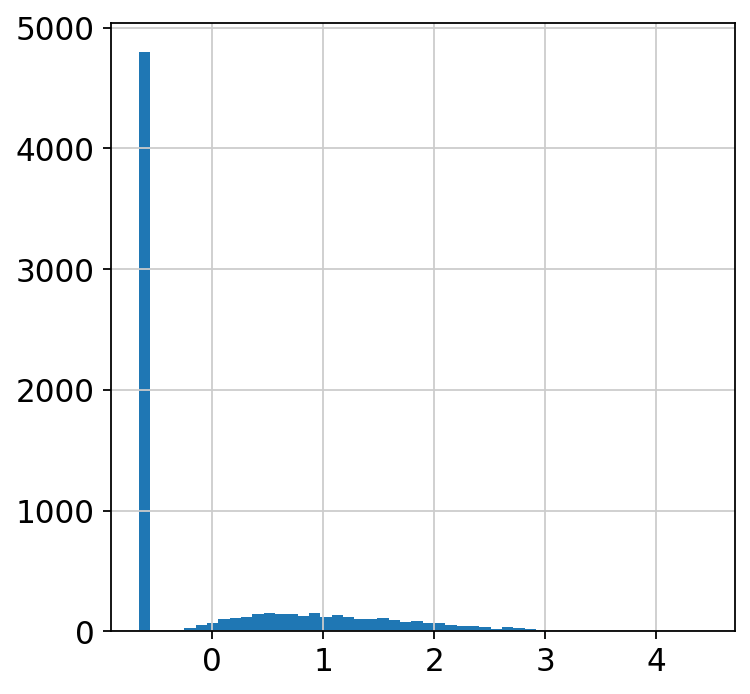

enter loop: 0
find1


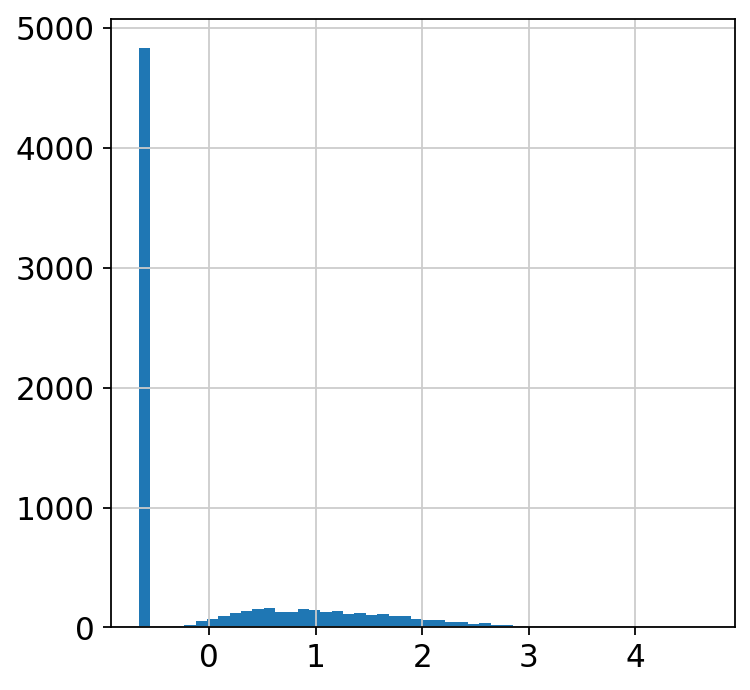

enter loop: 0
find2


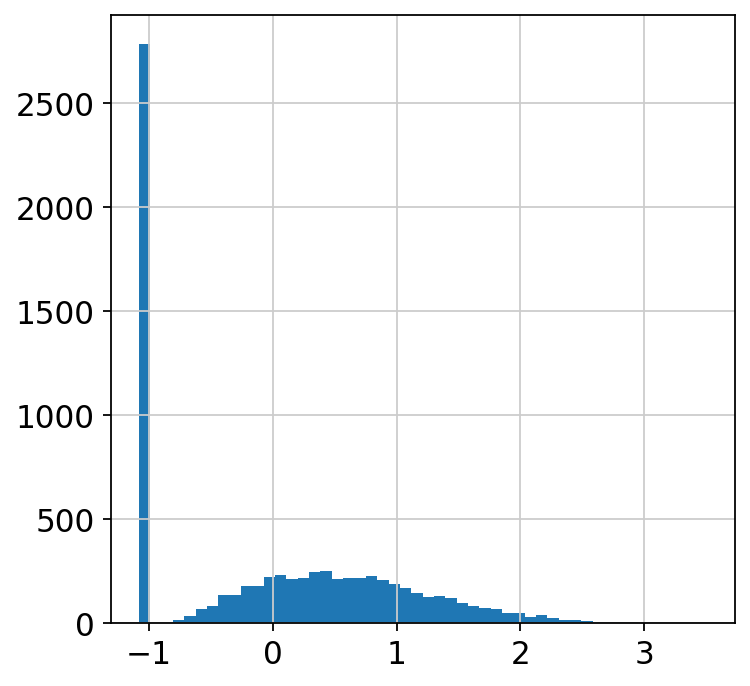

enter loop: 0
find3


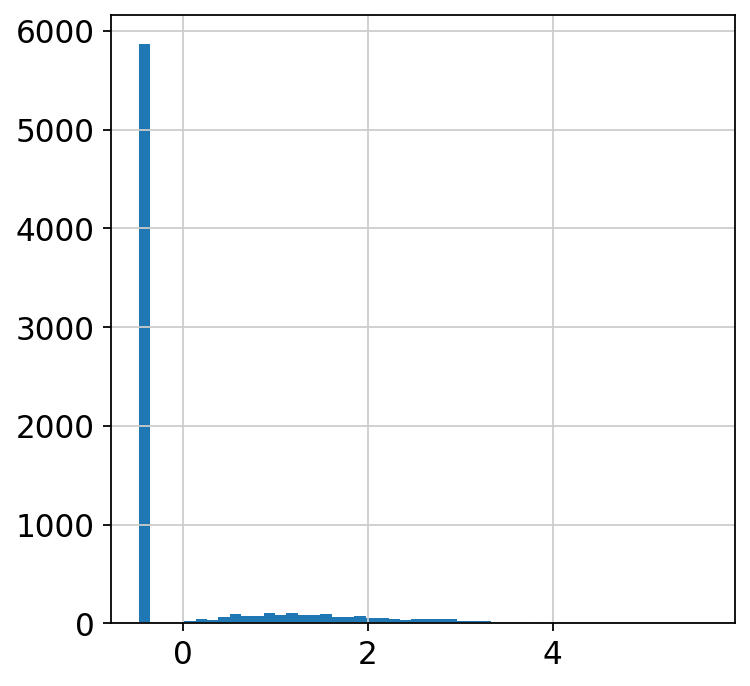

enter loop: 0
find4


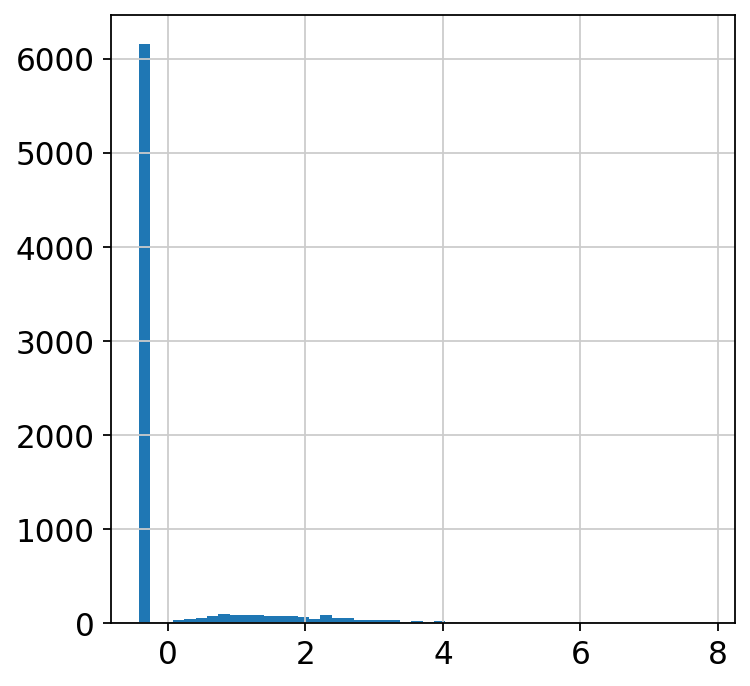

enter loop: 0
find5


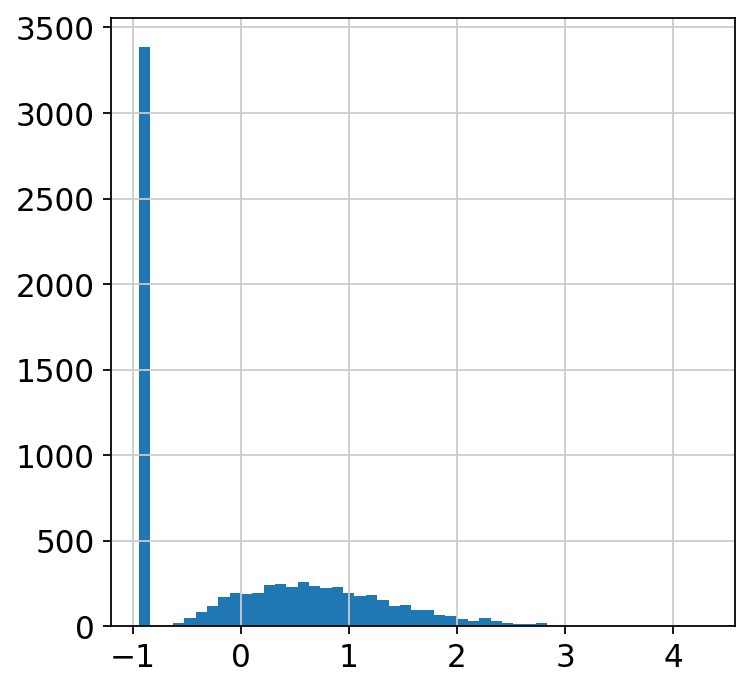

enter loop: 0
find6


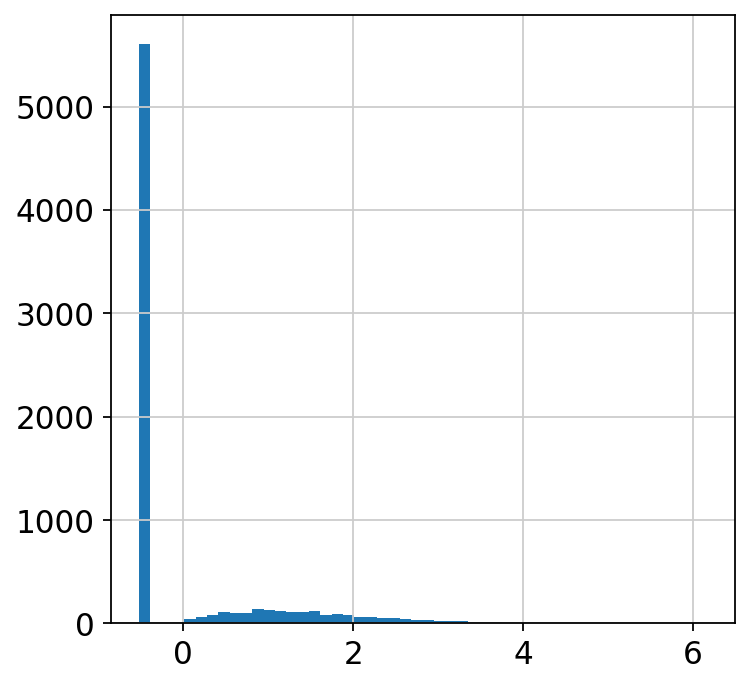

enter loop: 0
find7


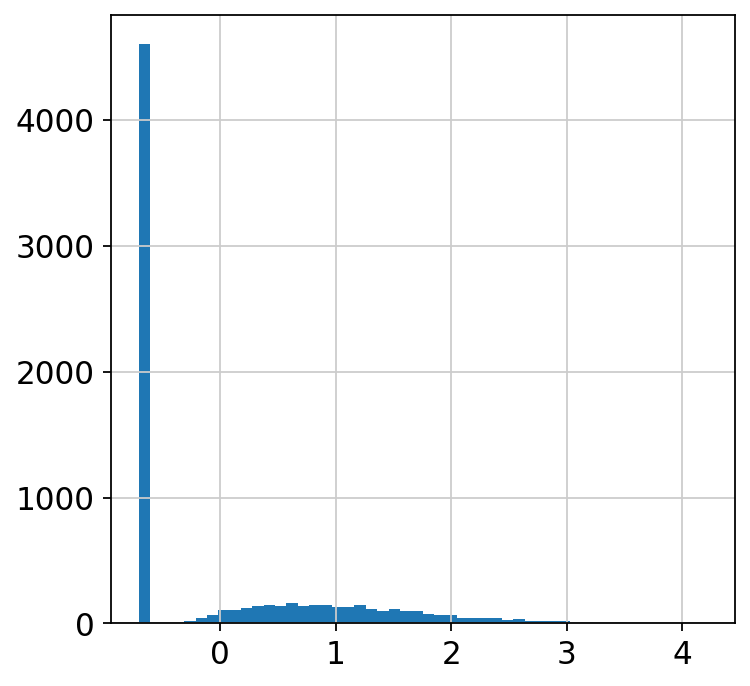

[-0.559562, -0.5549514, -0.9876671, -0.35546702, -0.2575393, -0.83845127, -0.38988003, -0.60380435]


In [16]:
asc_thresh_df = get_thresh_from_hist(asc_df, ck_genes, bins = 50, cut_off_diff = 2000)
#asc_thresh_df

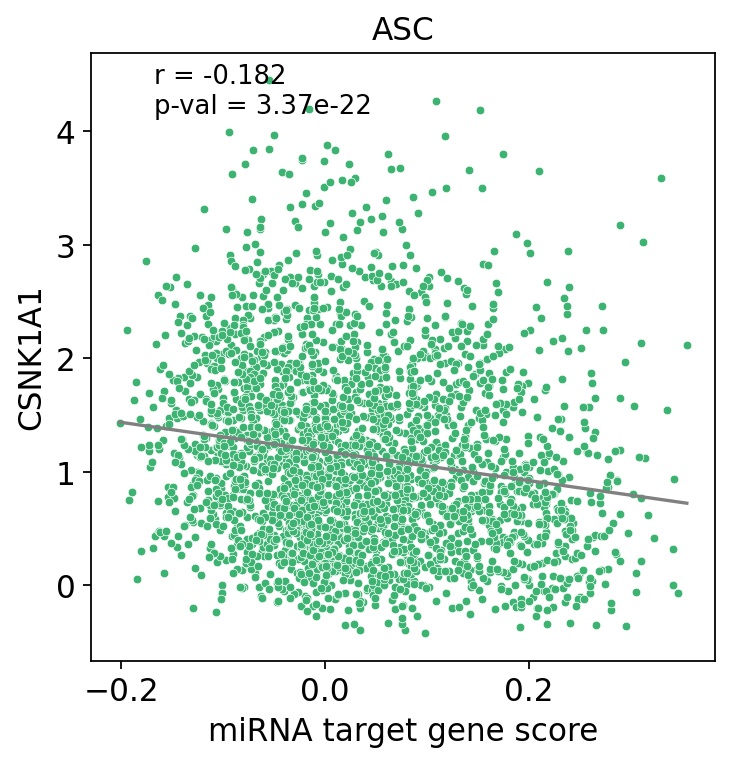

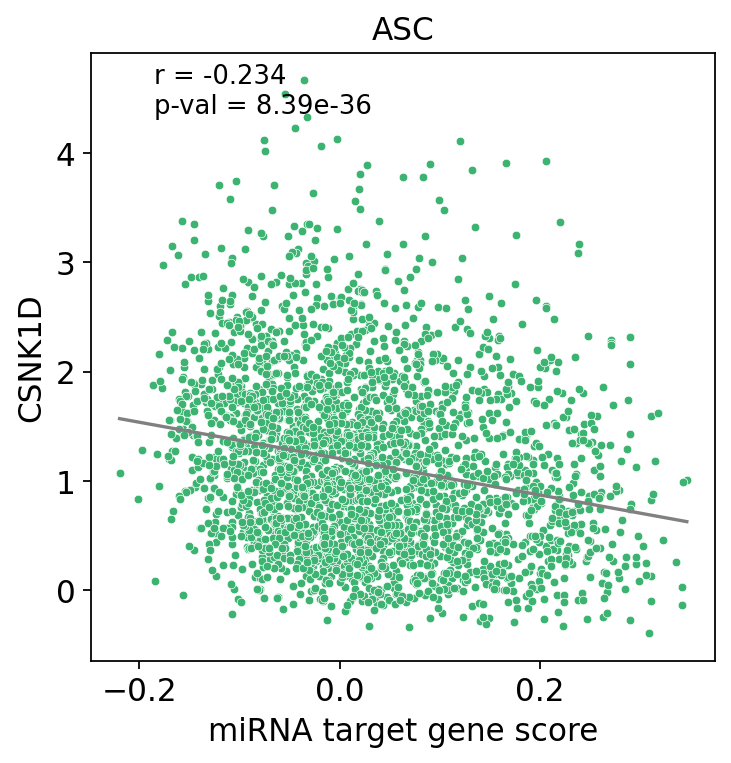

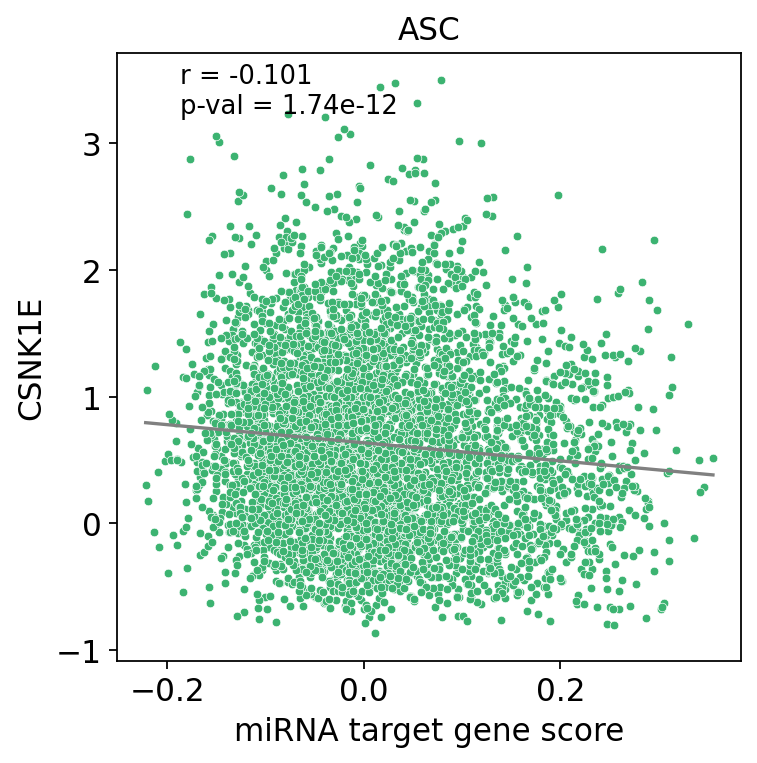

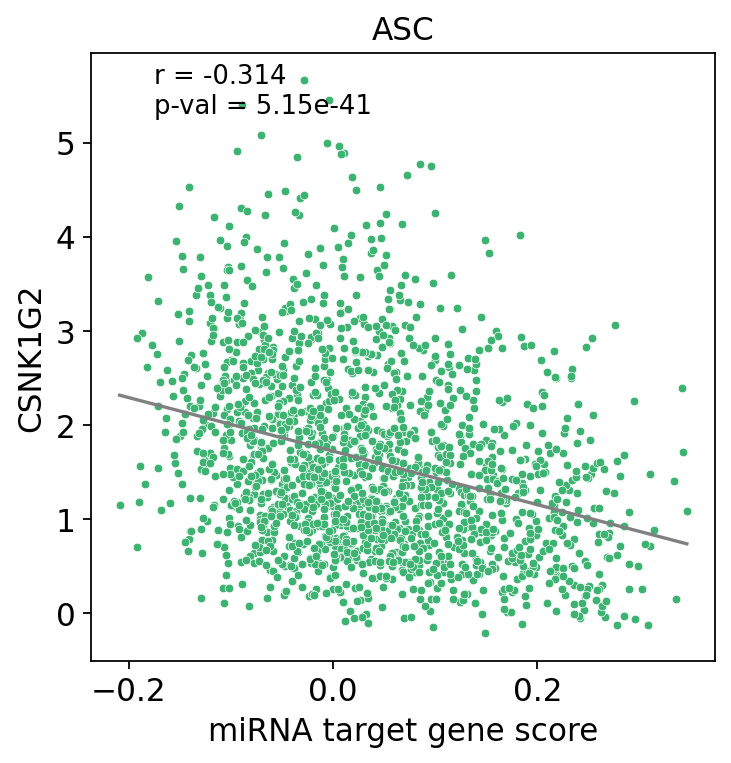

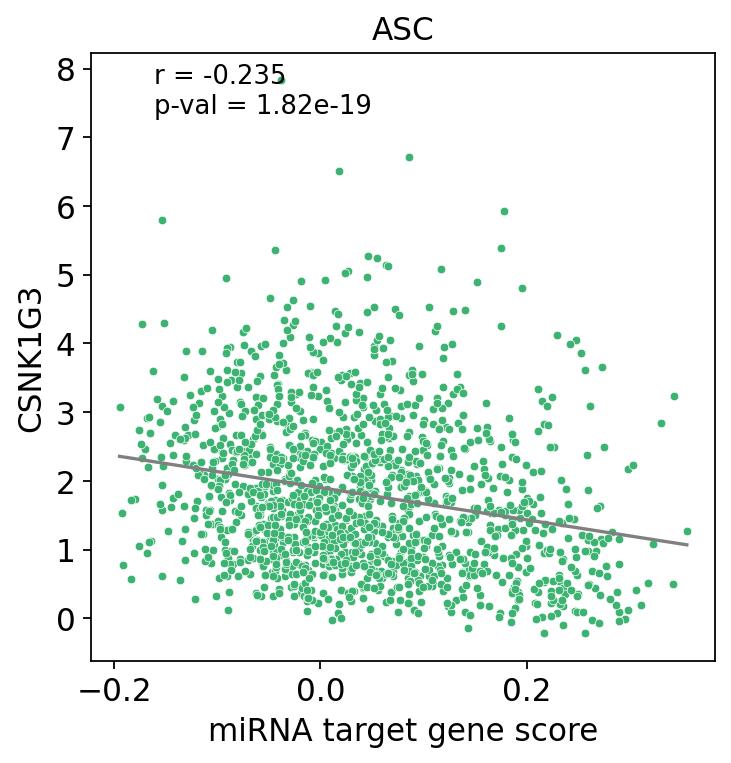

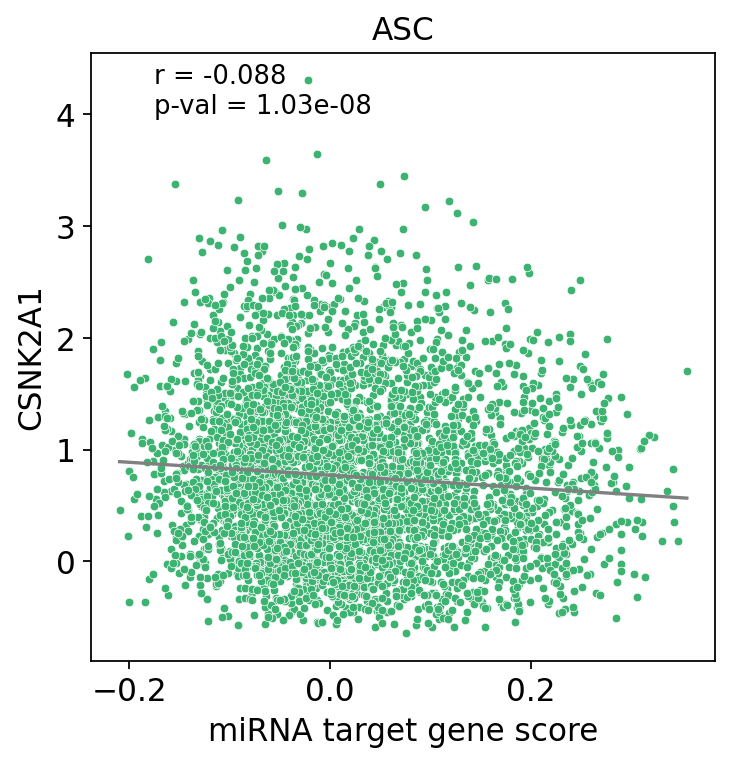

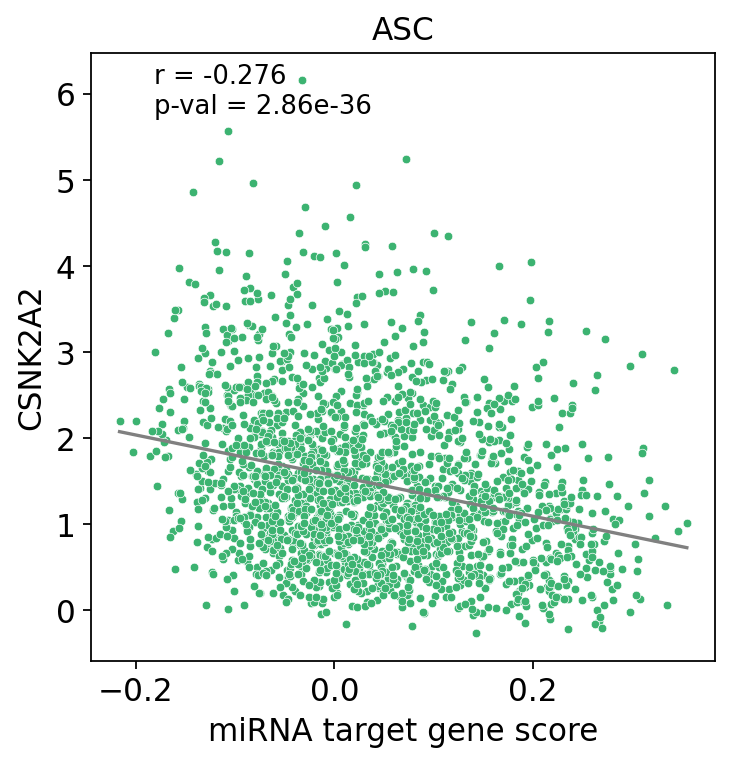

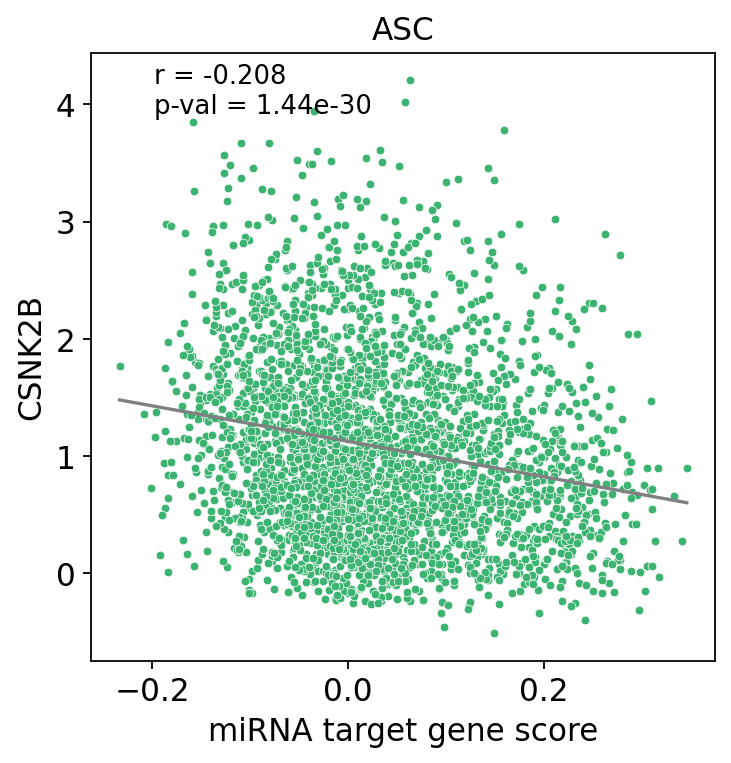

In [20]:
for i in range(len(ck_genes)):
    scater_correlation_with_thresh(asc_df, x="all_targets",y = ck_genes[i],
                                   plot_title = 'ASC', y_thresh = asc_thresh_df[ck_genes[i]][0], hue = None,
                                  )
#save =  save_fig_path + "ASC"+ ck_genes[i]+".pdf"

## SSC Analysis

In [ ]:
ssc = sc.read(os.path.join(data_path, "ssc.h5ad"))

In [ ]:
ssc.raw = ssc
calc.normalization(ssc)

In [42]:
ssc_df = pd.concat([pd.DataFrame(ssc.obs["all_targets"]), ssc.to_df()[ck_genes]], axis = 1)
ssc_df.head()

all_targets   CSNK1A1    CSNK1D    CSNK1E   CSNK1G2  \
GAGATCTCGGTGTACACG-0     -0.031937 -0.643622  1.810695  0.796870  1.042809   
TGAAAACAGGGACGGTAGC-0    -0.135133 -0.643622 -0.994788 -0.762971 -0.700147   
GAAGGAAGACGATTAGAC-0     -0.056872 -0.643622 -0.994788  1.631252 -0.700147   
GCTCTAGTTAGTGGAC-0       -0.038386 -0.643622 -0.994788  1.429018 -0.700147   
GATCTCAACCGGACTTCC-0      0.027769  2.759669  1.625562 -0.762971 -0.700147   

                       CSNK1G3   CSNK2A1   CSNK2A2    CSNK2B  
GAGATCTCGGTGTACACG-0  -0.47104  0.440842 -0.454924  1.515118  
TGAAAACAGGGACGGTAGC-0 -0.47104 -0.953277 -0.454924 -0.871085  
GAAGGAAGACGATTAGAC-0  -0.47104  1.186576 -0.454924  2.422558  
GCTCTAGTTAGTGGAC-0    -0.47104 -0.953277 -0.454924 -0.871085  
GATCTCAACCGGACTTCC-0  -0.47104 -0.953277 -0.454924 -0.871085

In [43]:
ssc.n_obs*0.4

1468.0

enter loop: 0
find0


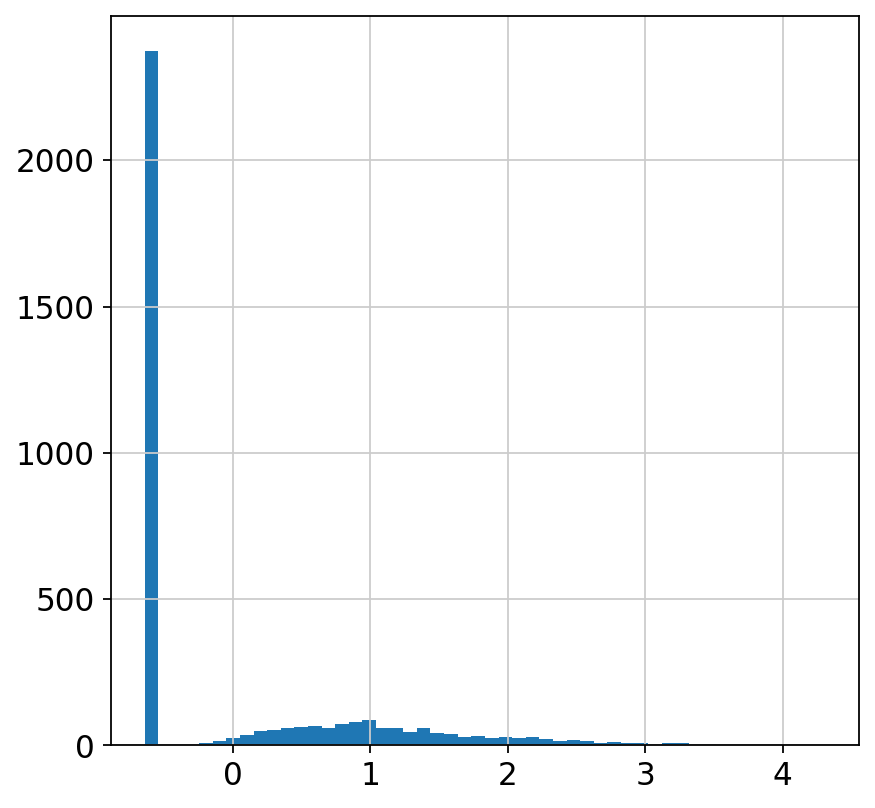

enter loop: 0
find1


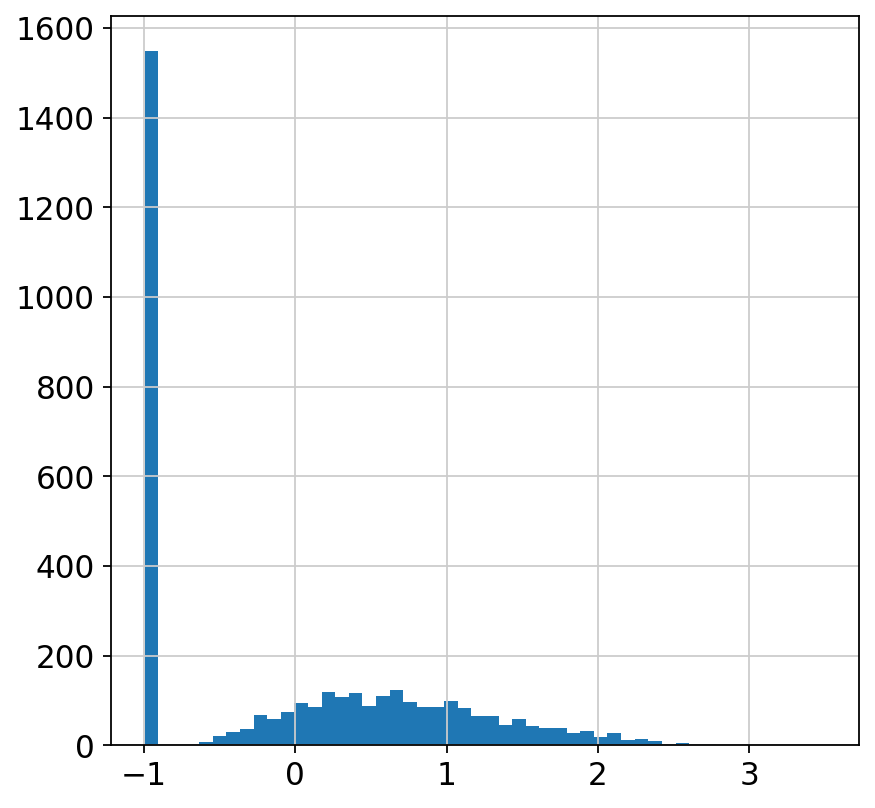

enter loop: 0
find2


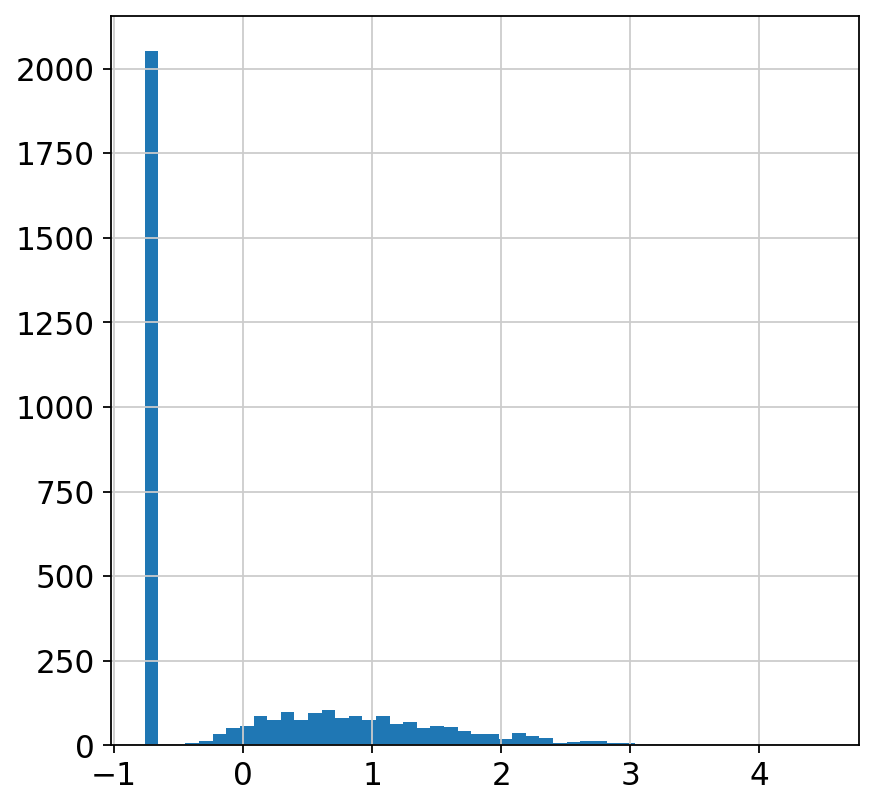

enter loop: 0
find3


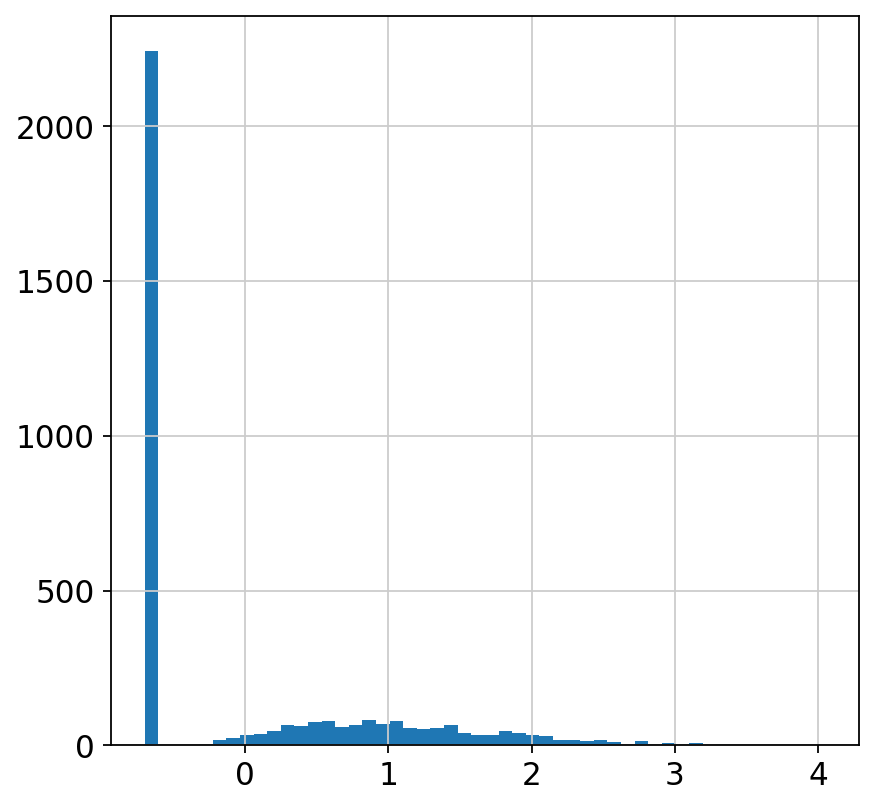

enter loop: 0
find4


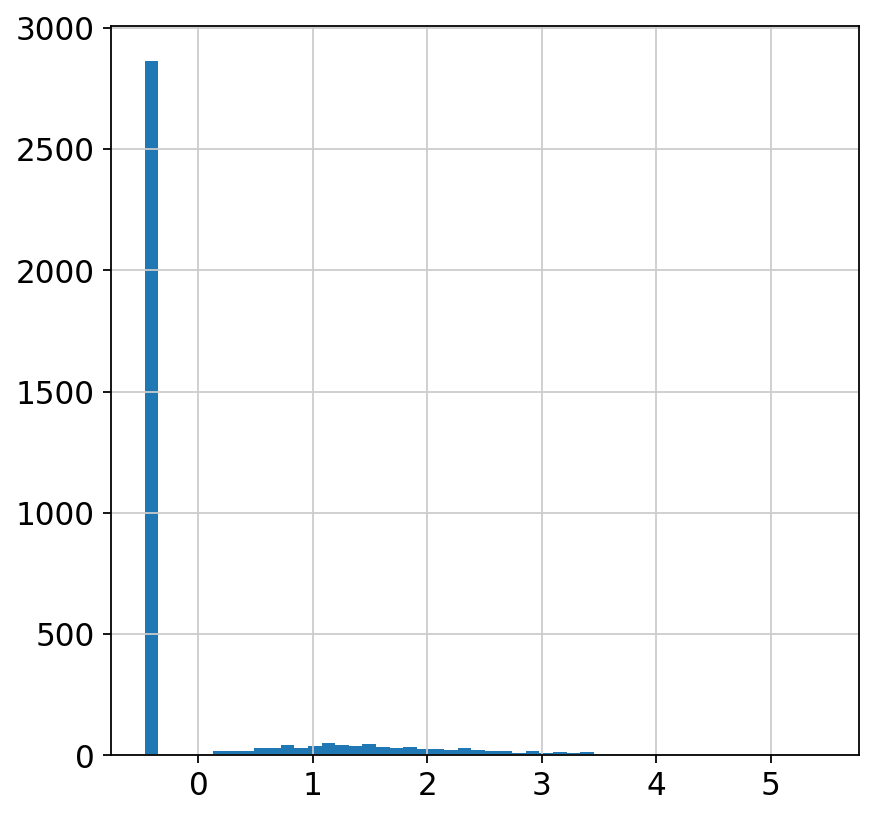

enter loop: 0
find5


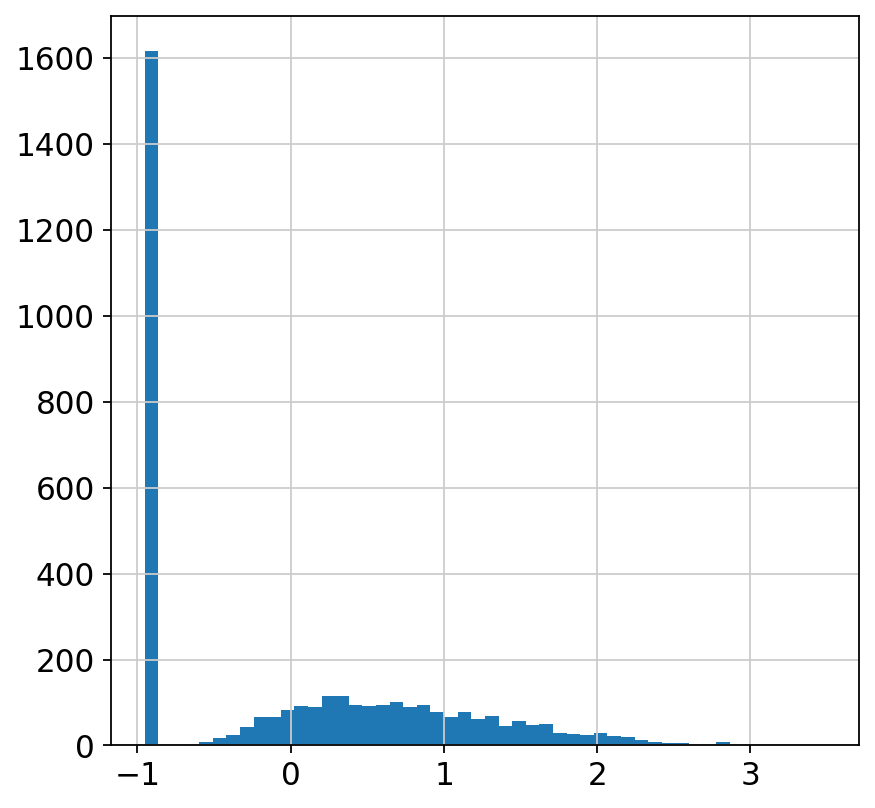

enter loop: 0
find6


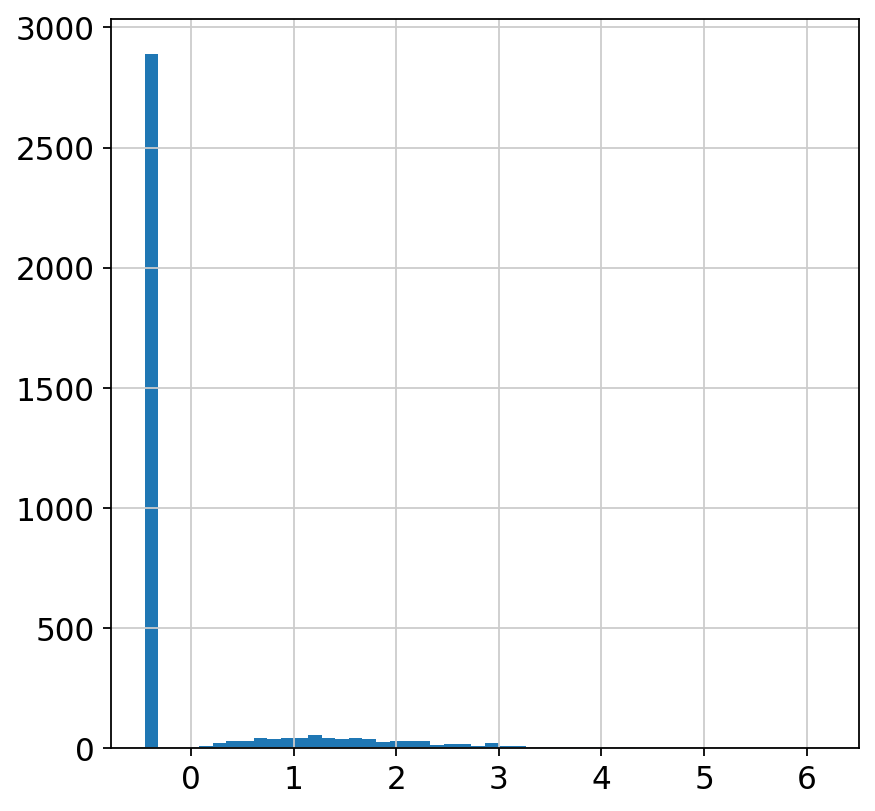

enter loop: 0
find7


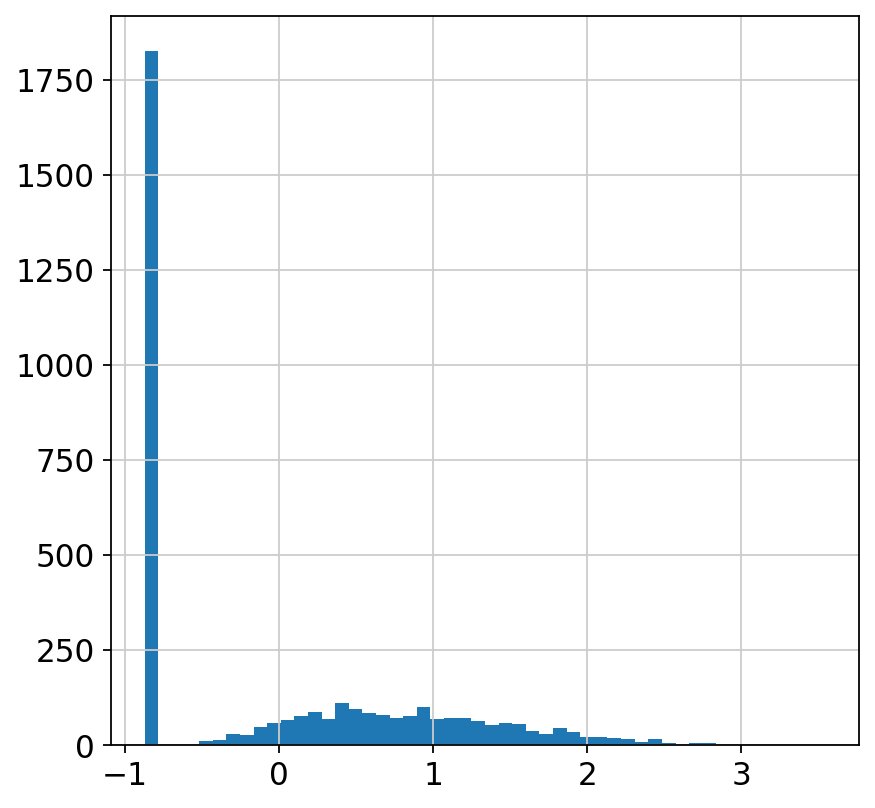

[-0.5445634, -0.9048471, -0.6575068, -0.6051487, -0.35204908, -0.8644477, -0.3221665, -0.78278744]


In [44]:
ssc_thresh_df = get_thresh_from_hist(ssc_df, ck_genes, bins = 50, cut_off_diff = ssc.n_obs*0.4)

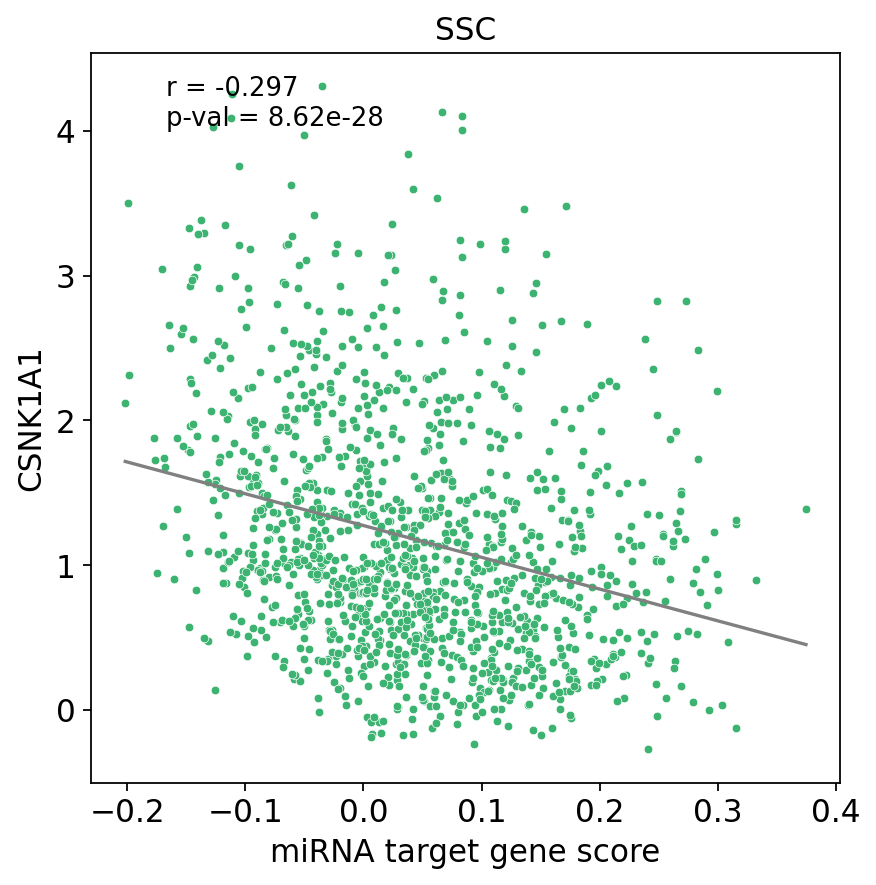

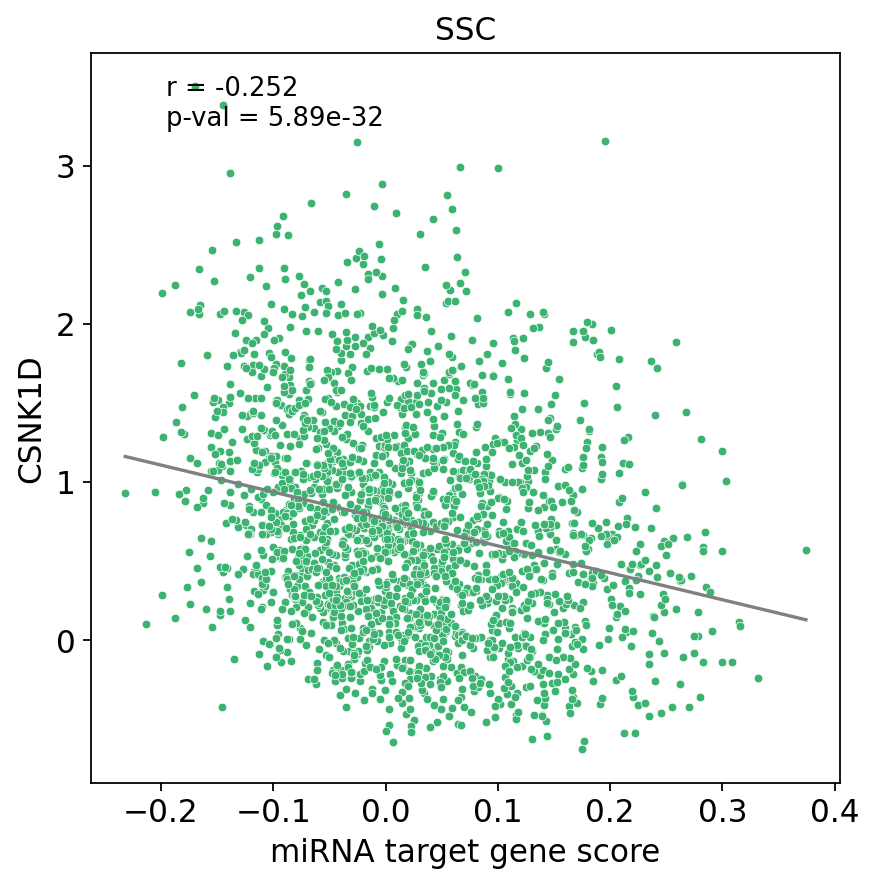

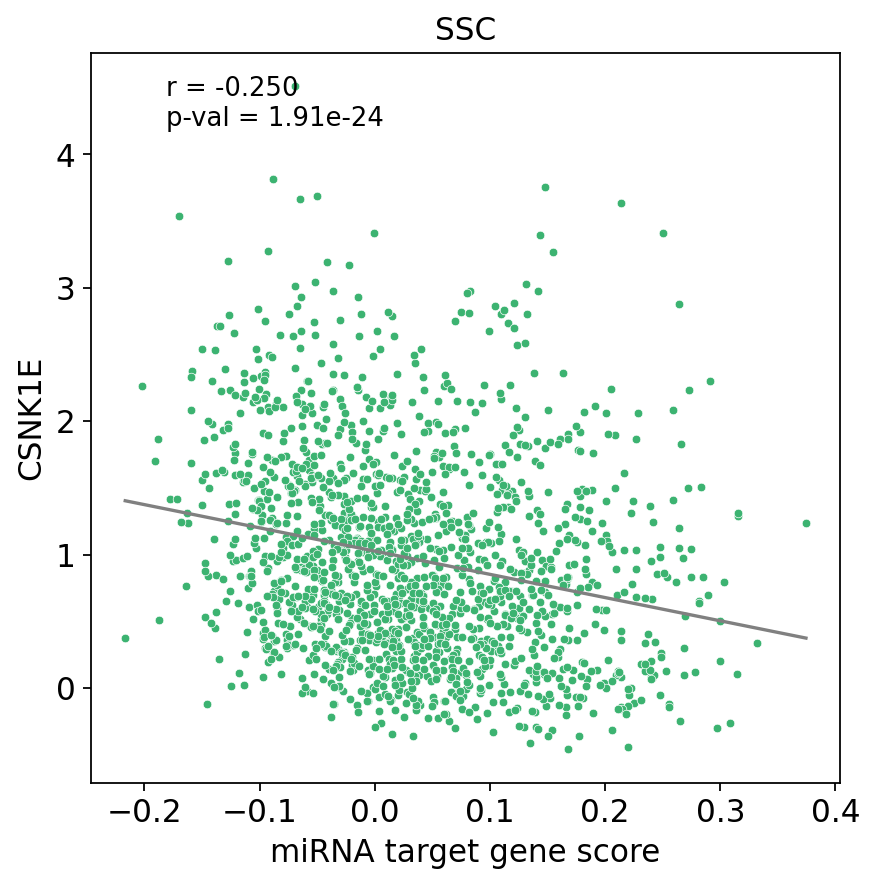

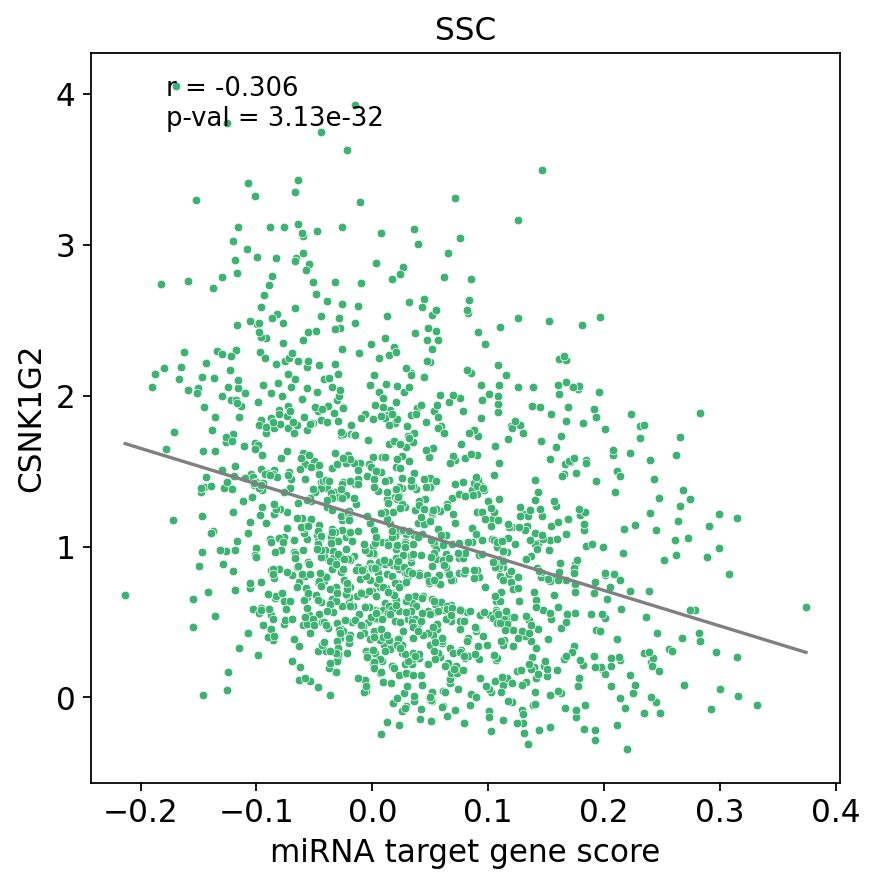

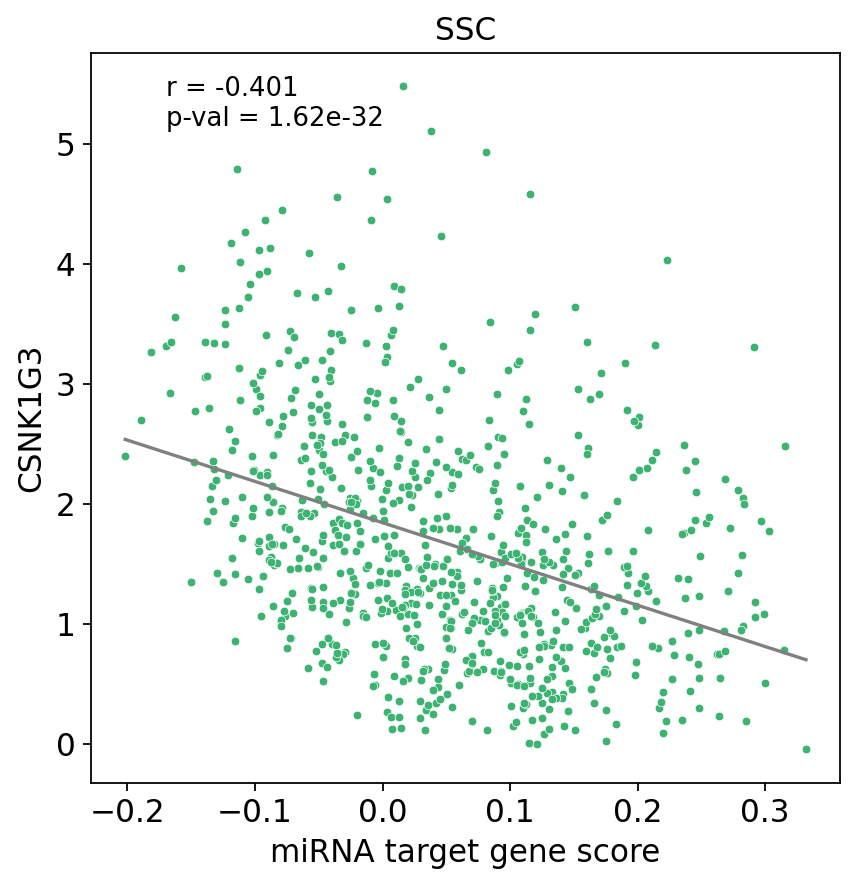

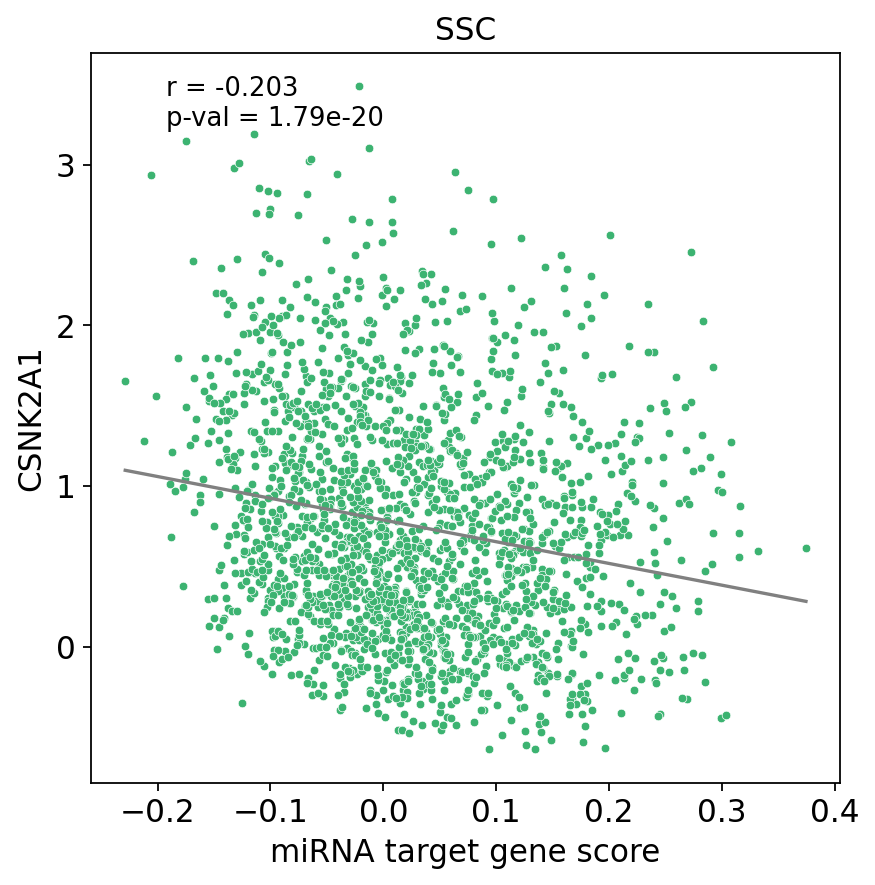

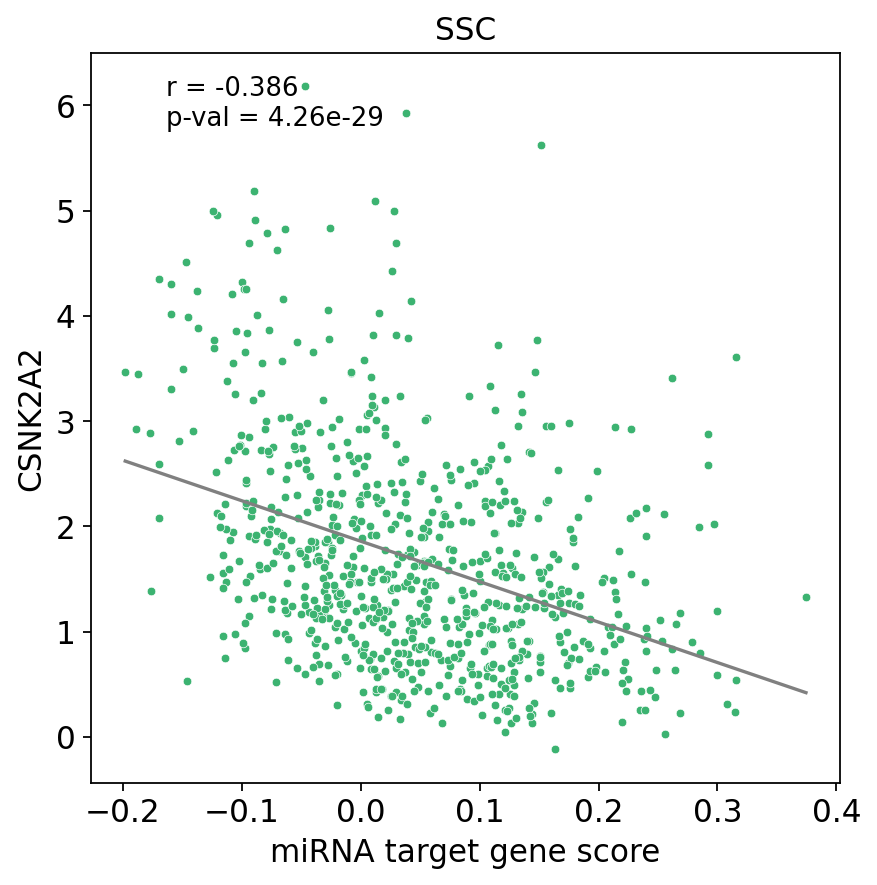

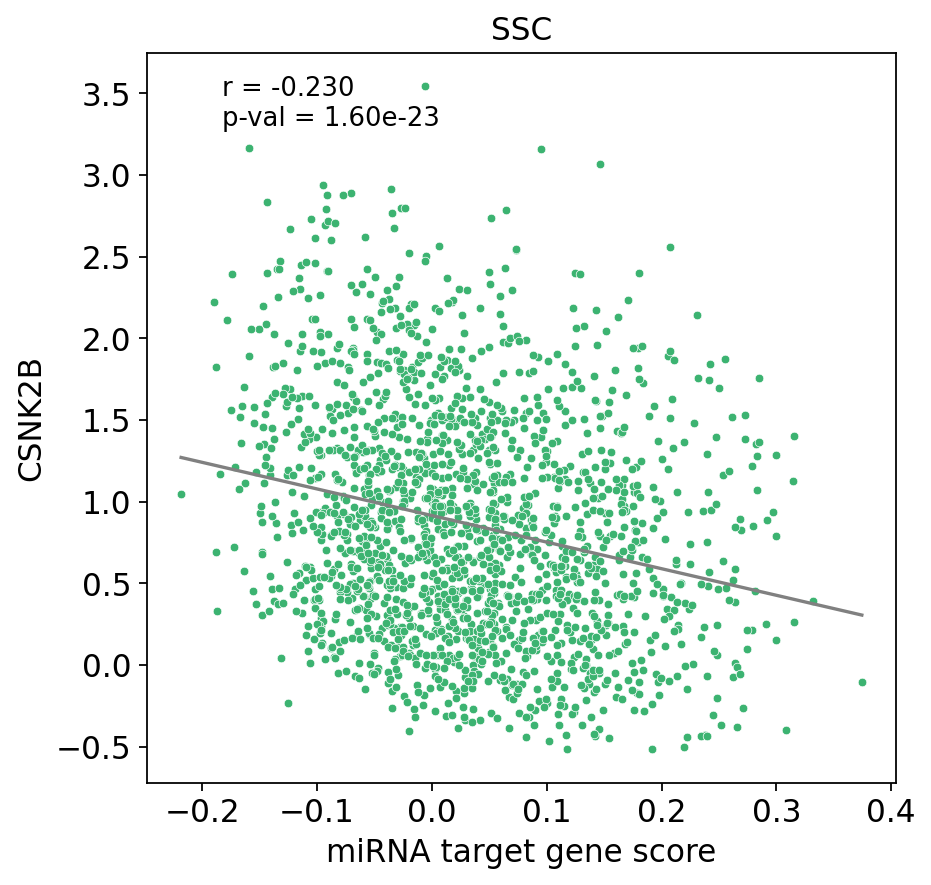

In [45]:
for i in range(len(ck_genes)):
    scater_correlation_with_thresh(ssc_df, x="all_targets",y = ck_genes[i],
                                   plot_title = 'SSC', y_thresh = ssc_thresh_df[ck_genes[i]][0], hue = None, 
                                   )
    #save =  save_fig_path + "SSC_"+ ck_genes[i]+".pdf"

## GOB Analysis

In [ ]:
gob = sc.read(os.path.join(data_path, "gob.h5ad"))

In [ ]:
gob.raw = gob
calc.normalization(gob)

In [49]:
gob_df = pd.concat([pd.DataFrame(gob.obs["all_targets_gene_scores"]), gob.to_df()[ck_genes]], axis = 1)
gob_df.head()

all_targets_gene_scores   CSNK1A1    CSNK1D    CSNK1E  \
AAATCAGAAGTGATGC-0                   -0.093048 -0.689113  1.469839 -0.875850   
GGCCCTTATGCGTATC-0                   -0.119510  2.598026 -0.681971  0.504125   
TTCGGCCTCTTCGCAC-0                   -0.106588 -0.689113 -0.681971 -0.875850   
TGATGTCTTTCAATCGGGT-0                -0.130230 -0.689113  0.961293 -0.875850   
TTATAGCCACCACGCT-0                   -0.093053  1.311232 -0.681971 -0.875850   

                        CSNK1G2   CSNK1G3   CSNK2A1   CSNK2A2    CSNK2B  
AAATCAGAAGTGATGC-0    -0.429622 -0.416206 -0.857528 -0.395797 -0.611861  
GGCCCTTATGCGTATC-0    -0.429622  2.001024  0.557797 -0.395797 -0.611861  
TTCGGCCTCTTCGCAC-0    -0.429622 -0.416206  1.206805 -0.395797 -0.611861  
TGATGTCTTTCAATCGGGT-0 -0.429622 -0.416206 -0.857528 -0.395797 -0.611861  
TTATAGCCACCACGCT-0    -0.429622 -0.416206 -0.857528  2.834472 -0.611861

In [50]:
gob.n_obs*0.4

4331.6

enter loop: 0
find0


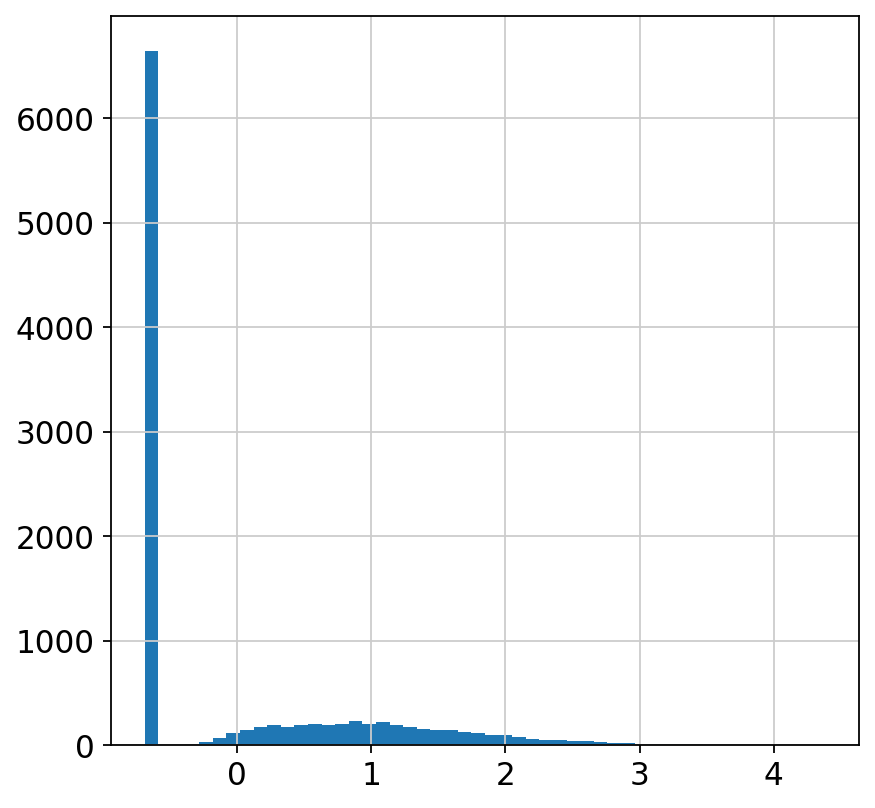

enter loop: 0
find1


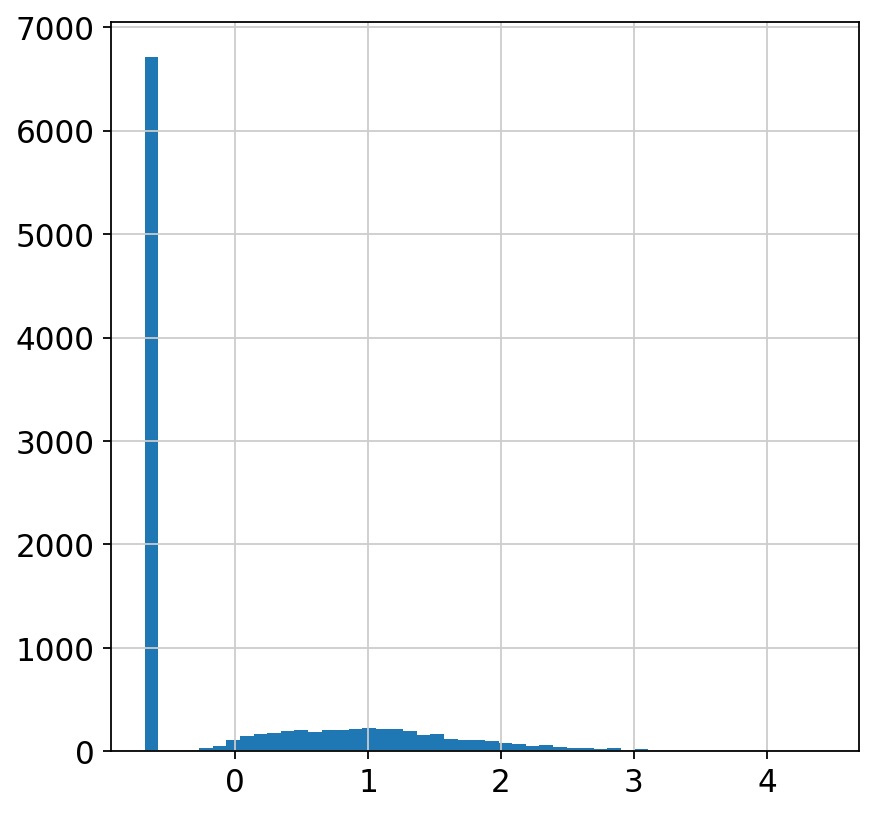

enter loop: 0
find2


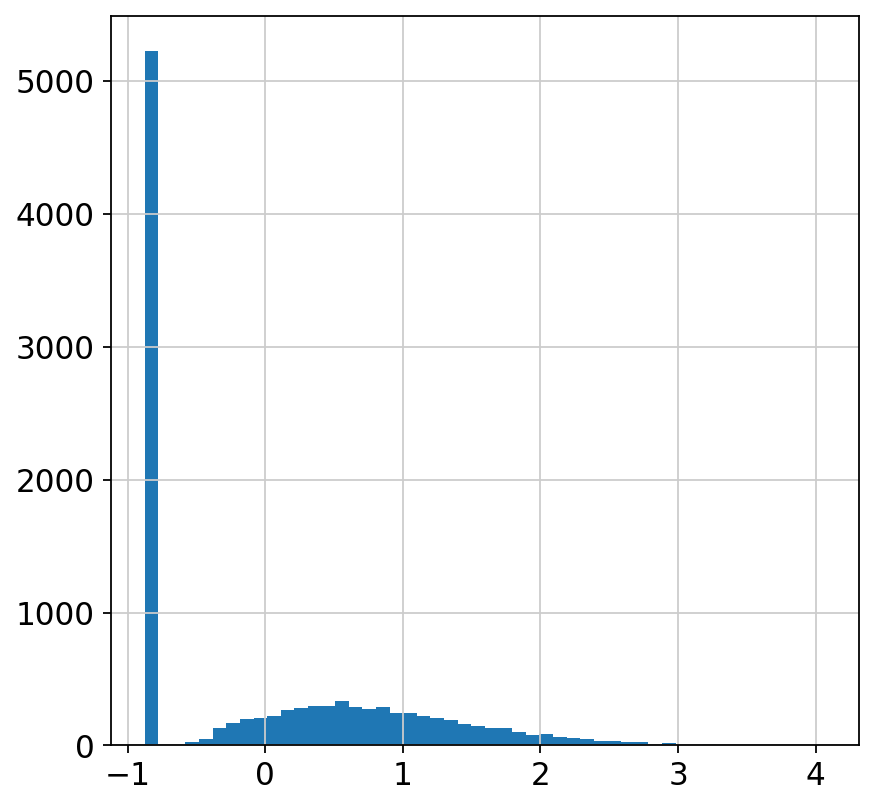

enter loop: 0
find3


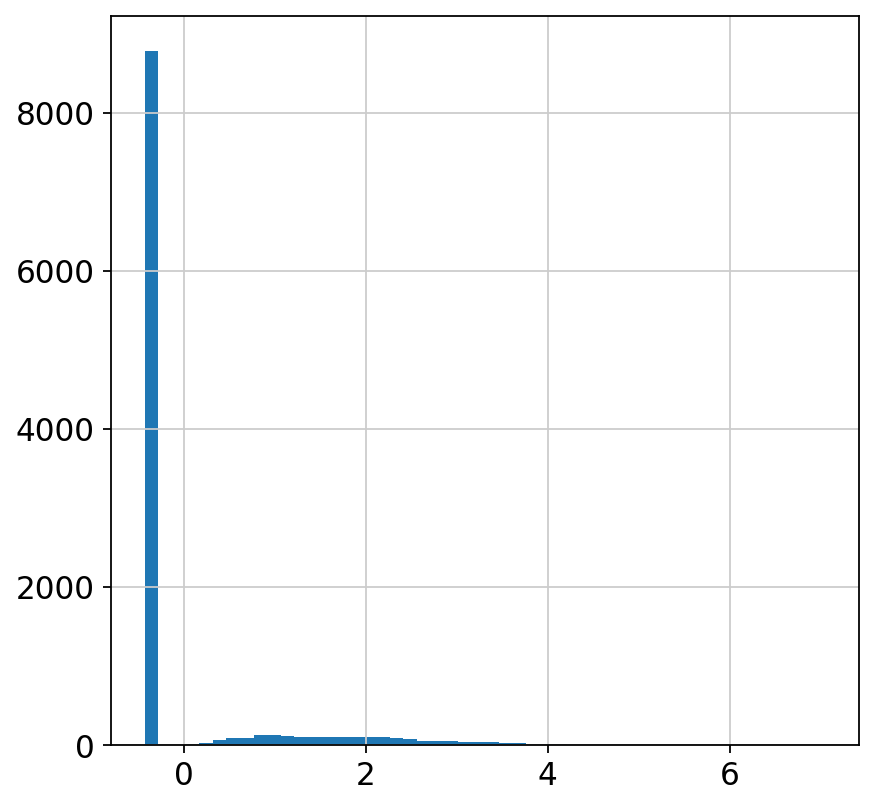

enter loop: 0
find4


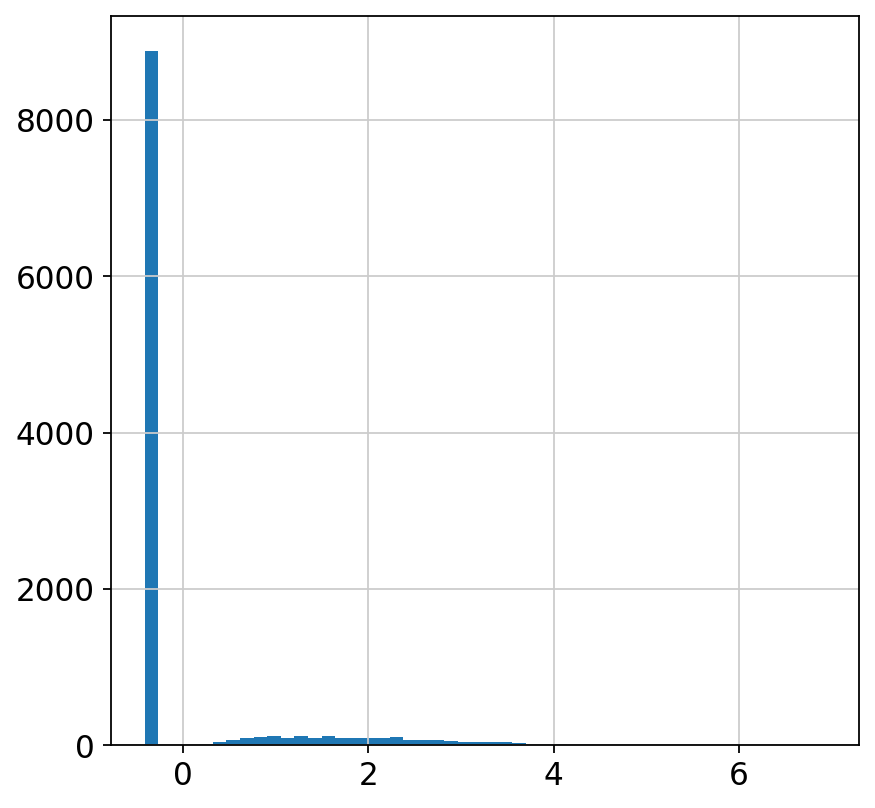

enter loop: 0
find5


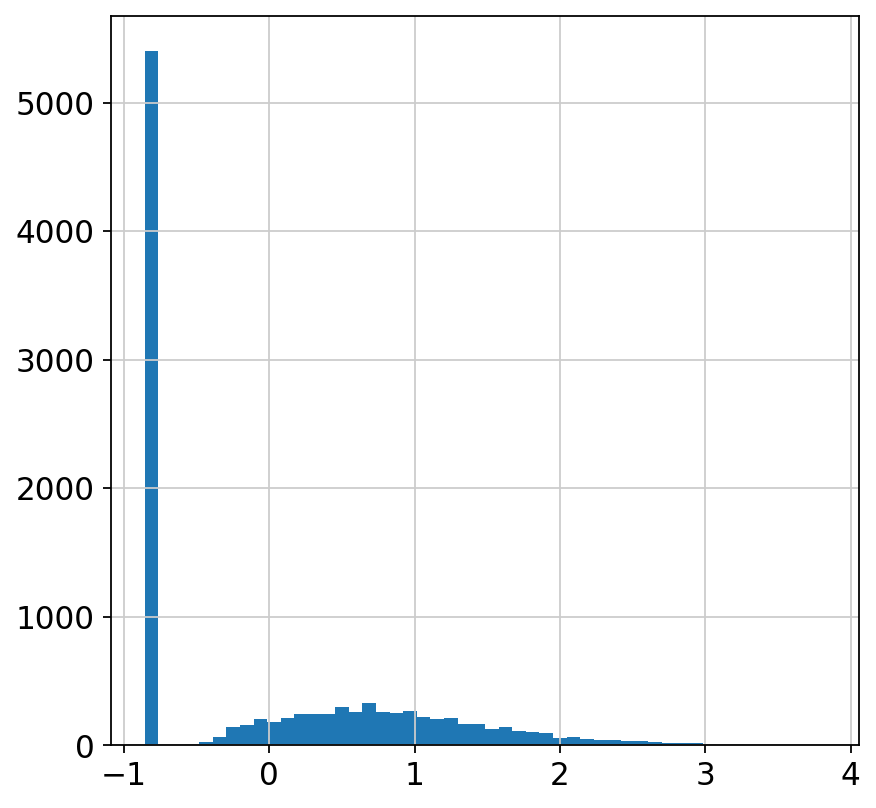

enter loop: 0
find6


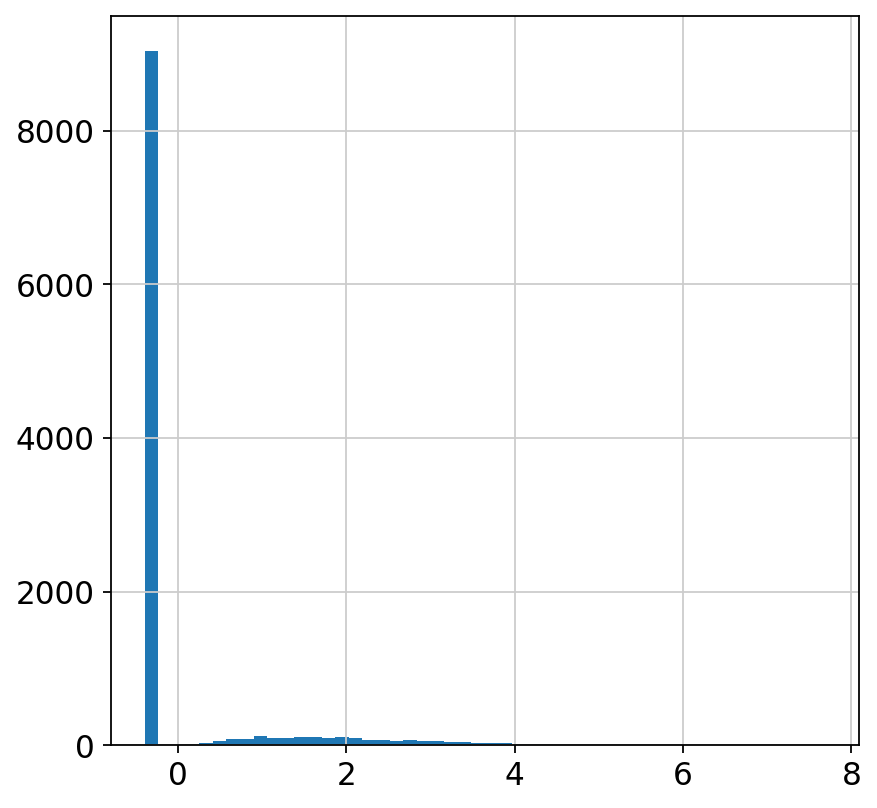

enter loop: 0
find7


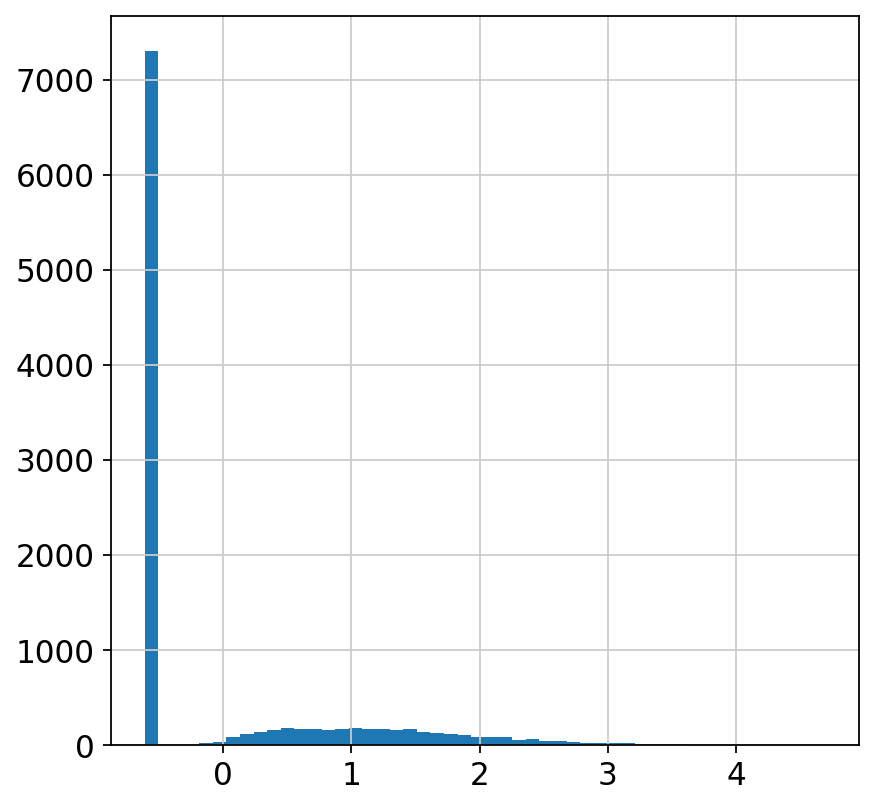

[-0.5876454, -0.5795381, -0.77695465, -0.27998796, -0.26919037, -0.7638496, -0.23406263, -0.5057167]


In [51]:
gob_thresh_df = get_thresh_from_hist(gob_df, ck_genes, bins = 50, cut_off_diff = gob.n_obs*0.4)

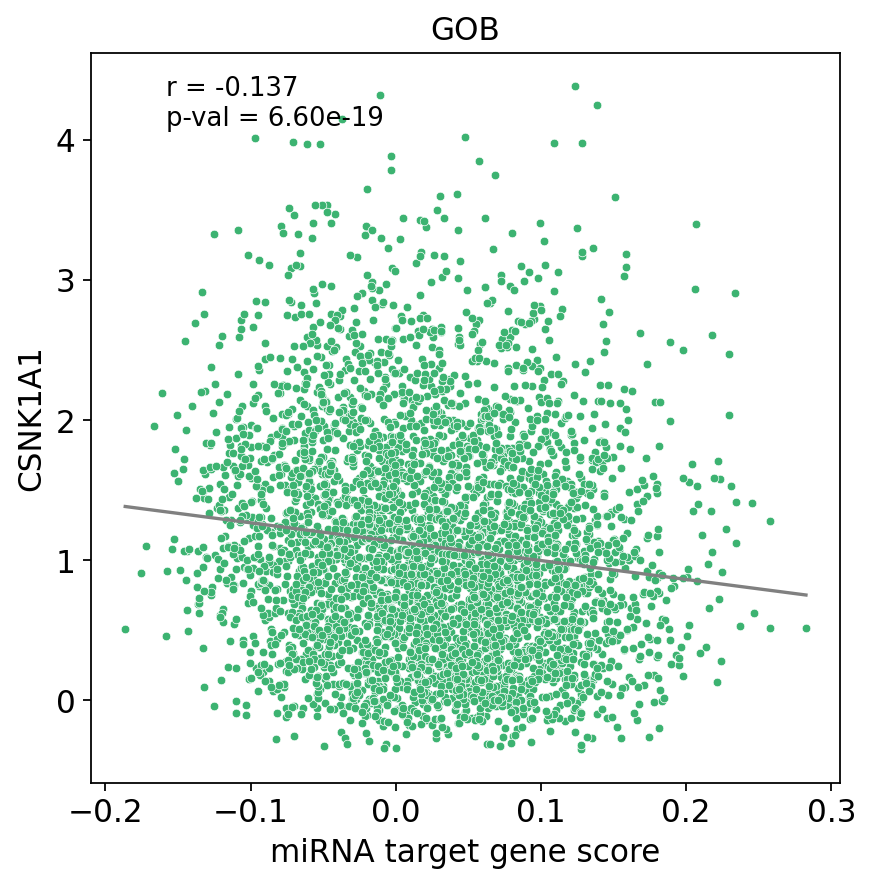

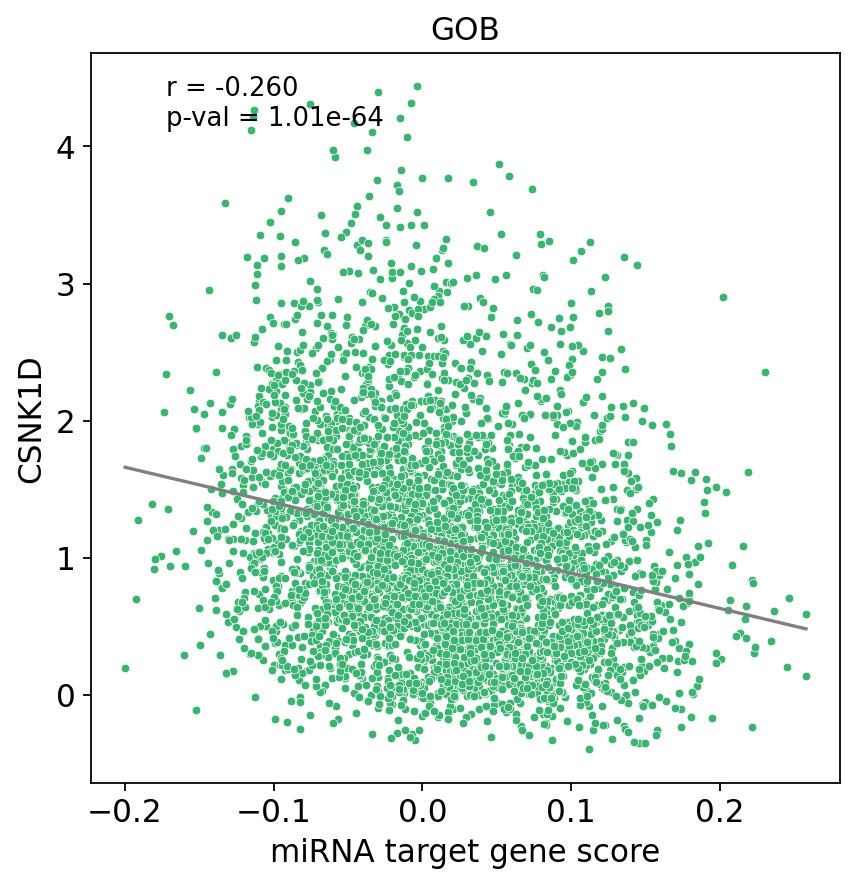

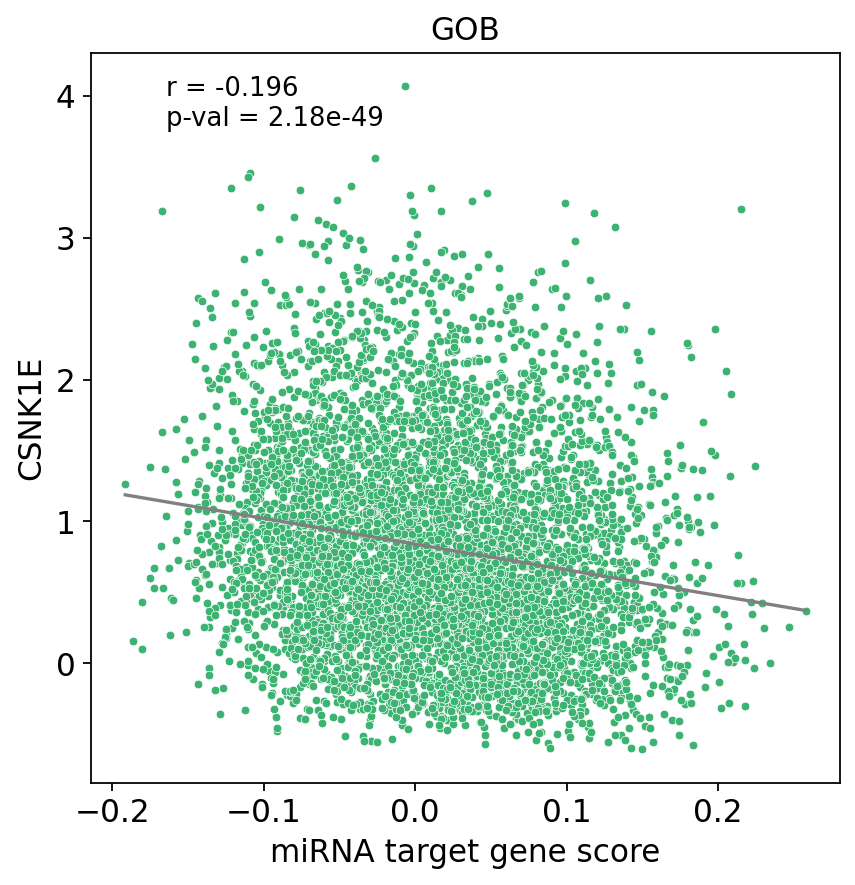

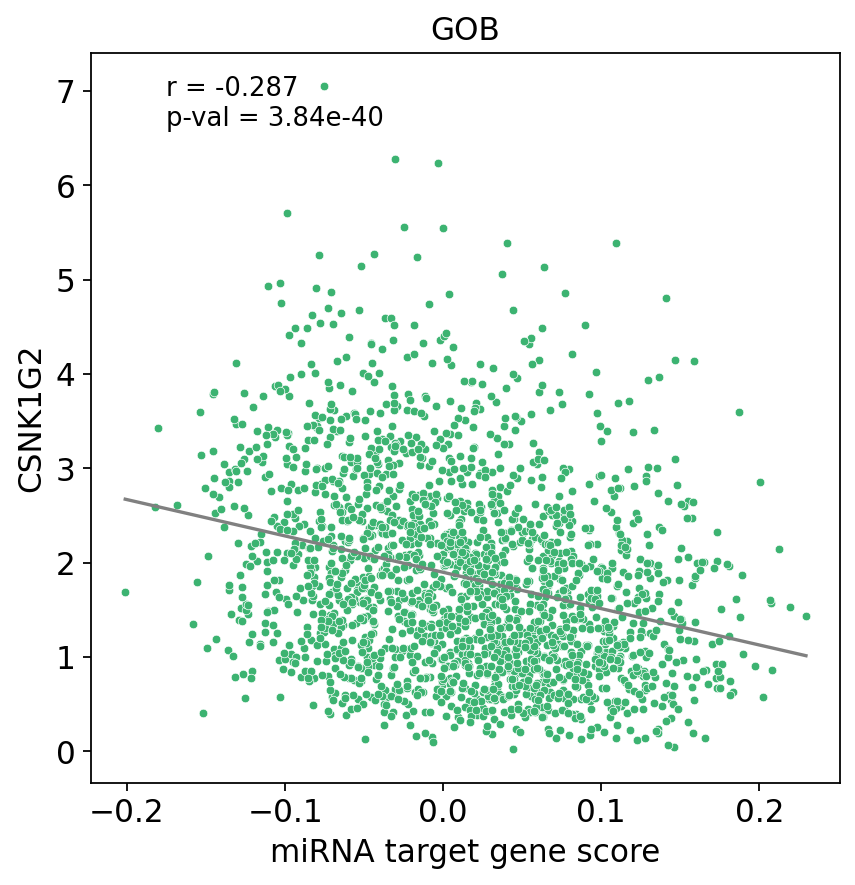

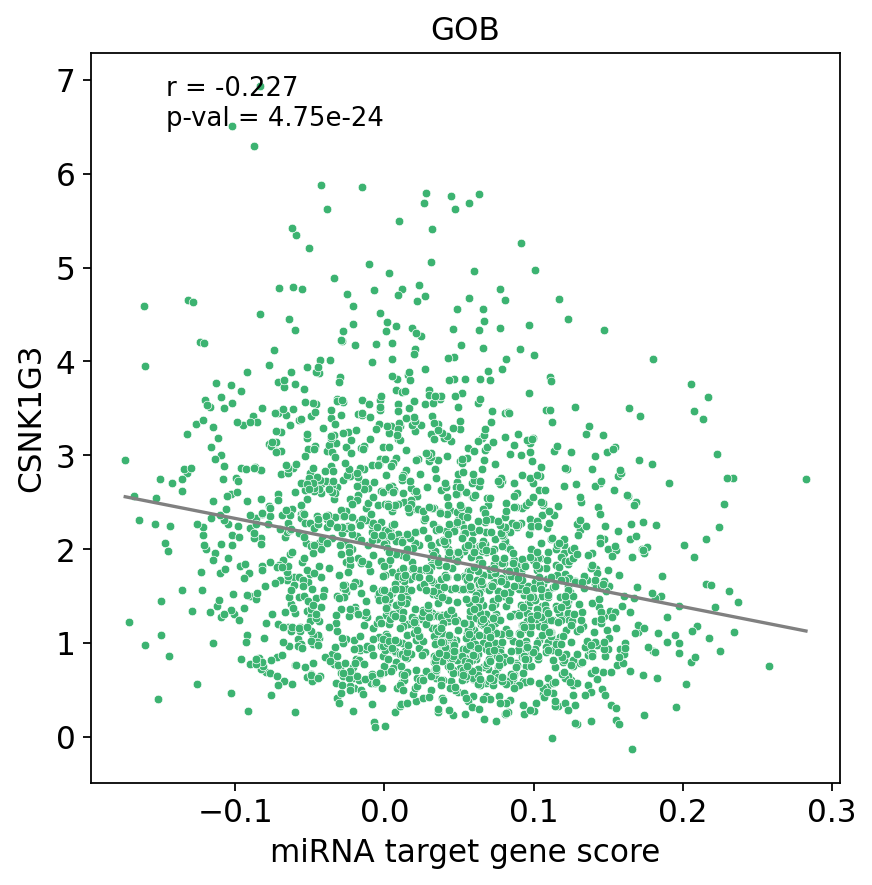

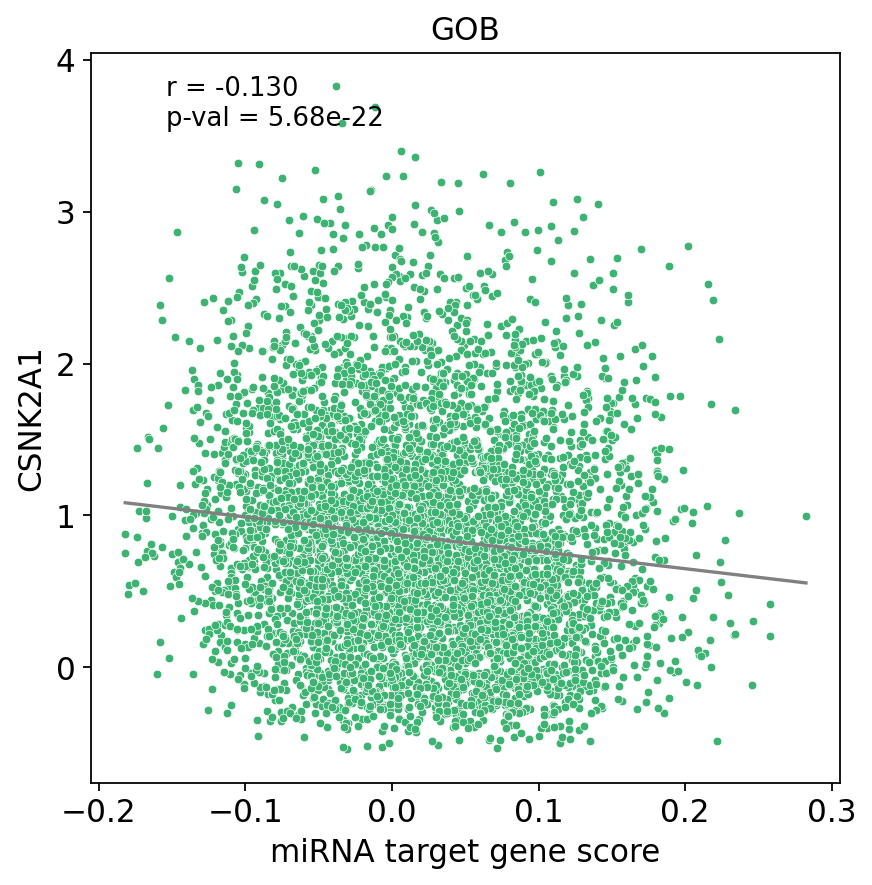

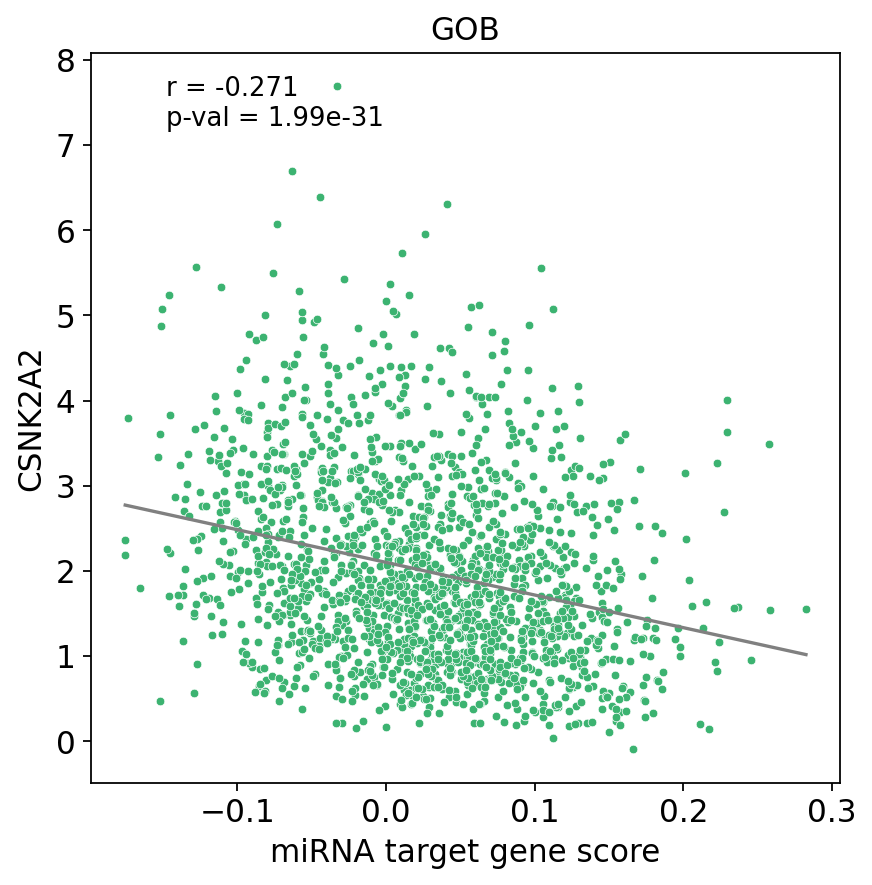

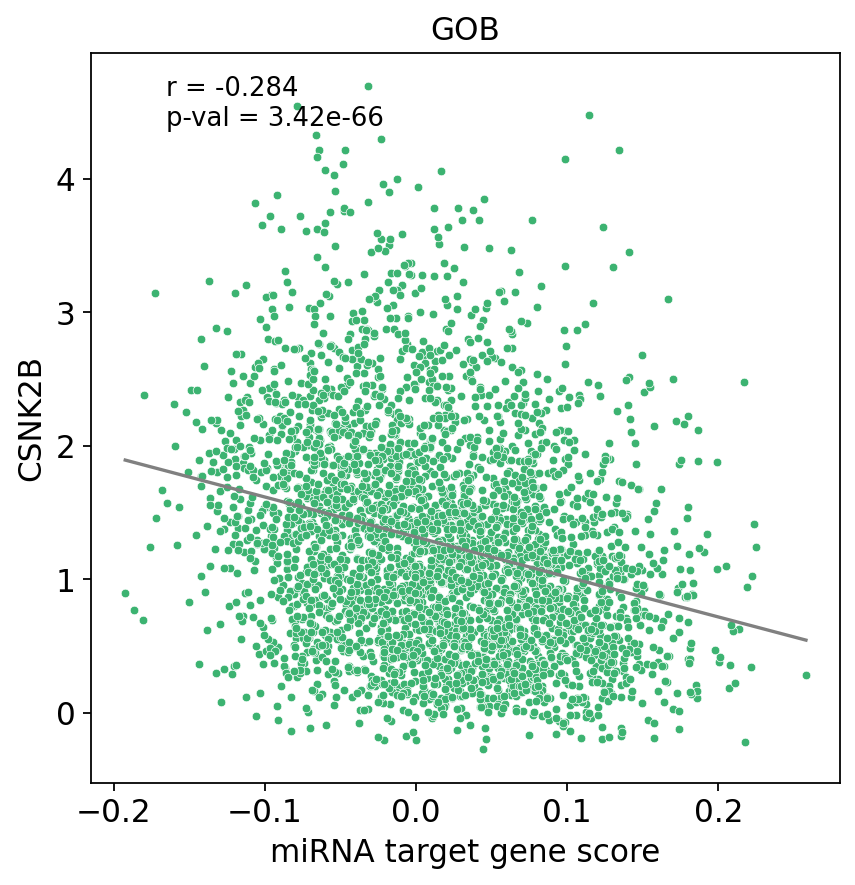

In [52]:
for i in range(len(ck_genes)):
    scater_correlation_with_thresh(gob_df, x="all_targets_gene_scores",y = ck_genes[i],
                                   plot_title = 'GOB', y_thresh = gob_thresh_df[ck_genes[i]][0], hue = None,
                                  )
    #save =  save_fig_path + "GOB_"+ ck_genes[i]+".pdf"